# Import

In [5]:
from joblib import Parallel, delayed
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np 
from os import path
import pandas as pd 
import os
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#os.environ["CUDA_VISIBLE_DEVICES"] = '1'
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots
#import tensorflow_docs.modeling
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
import datetime
import math
import time
import pickle
import random
from scipy.spatial import cKDTree
from sklearn import preprocessing
from sklearn.decomposition import PCA
import sys
from sklearn.metrics import r2_score as r2
#from rdkit import Chem
from sklearn.decomposition import PCA
import rishi_utils as ru

import importlib
import efrc_ml_production as ml
importlib.reload(ml)
importlib.reload(ru)
from skopt import gp_minimize

from multiprocessing import Pool

In [6]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.enable_eager_execution()
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from sklearn.model_selection import LeaveOneOut,KFold

# New

In [12]:
class hmofMLdataset:
    def __init__(self, results_dir, now, SI_grav_data_path='/data/rgur/efrc/prep_data/all_v1/ml_data.csv', 
                 SD_grav_data_path='/data/rgur/efrc/prep_data/all_no_norm/ml_data.csv',SI_stacked_path=
                '/data/rgur/efrc/prep_data/all_v1/stacked.csv',
                 SD_stacked_path='/data/rgur/efrc/prep_data/all_no_norm/stacked.csv',
                 Y_DATA_PATH='/data/rgur/efrc/data_DONOTTOUCH/hMOF_allData_March25_2013.xlsx', n_core=15, skip=None, 
                 do=None, nn_space=None, grav_algo='xgb'):
        self.results_dir = results_dir 
        os.chdir(self.results_dir)
        self.SI_grav_data_path = SI_grav_data_path
        self.SD_grav_data_path = SD_grav_data_path
        self.SI_stacked_path = SI_stacked_path
        self.SD_stacked_path = SD_stacked_path
        self.n_core = n_core
        self.Y_DATA_PATH = Y_DATA_PATH
        self.del_defective_mofs = False
        self.cat_si_sd = True
        self.add_size_fp = True #make True if you want to add 20 feature columns, where each feature is the number of atoms in a linker
        self.srt_size_fp = True
        self.iso_start_str_sd = 'Density'
        self.iso_end_str_sd = 'norm_Dom._Pore_(ang.)'
        self.grav_start_str_sd = 'CH4_v/v_248_bar'
        self.grav_end_str_sd = 'norm_Dom._Pore_(ang.)'
        self.start_str_si = 'filename'
        self.end_str_si = 'valence_pa'
        self.cat_col_names = ['cat_1', 'cat_2', 'cat_3', 'cat_4']
        self.skip = skip
        self.feature_codes = ['10000', '11000', '01000', '10100', '11100', '01100',
                             '10010', '11010', '01010', '10110', '11110', '01110',
                             '10001', '11001', '01001', '10101', '11101', '01101',
                             '10011', '11011', '01011', '10111', '11111', '01111']
        self.do = do
        if self.do != None:
            self.feature_codes = self.do
        elif skip != None:
            self.feature_codes = [i for i in self.feature_codes if i not in self.skip]   
        print("There are %s unique feature codes" %len(set(self.feature_codes)))
        self.any_stacked = any([item[-1]=='1' for item in self.feature_codes]) #are any codes for stacked models?
        self.now = now
        print("now is %s" %self.now)
        self.nn_space = nn_space
        self.grav_algo = grav_algo
    def makeMasterDFs(self):
        #gravimetric
        self.grav, self.grav_prop, self.grav_target_mean, self.grav_target_std, self.grav_all_features = \
                                            ml.prepToSplit(
                                            self.grav_algo, self.cat_si_sd, self.SD_grav_data_path, self.SI_grav_data_path, 
                                            self.grav_start_str_sd, self.grav_end_str_sd, self.start_str_si, 
                                            self.end_str_si, 1, self.del_defective_mofs, self.add_size_fp, 
                                            self.srt_size_fp, None, stacked=False, n_core=self.n_core, 
                                            del_geometric_fp=False, cat_col_names=self.cat_col_names, 
                                            Y_DATA_PATH=self.Y_DATA_PATH
                                            )
        size_cols = ["size_%s" %s for s in range(20)]
        self.LS_dict = {row[1]['filename']:row[1][size_cols] for row in self.grav.iterrows()} # map from filename 
                                                                                        #to linkersize-vector
        #stacked
        if self.any_stacked:
            self.iso, self.iso_prop, self.iso_target_mean, self.iso_target_std, self.iso_all_features, self.pinfo = \
                                                ml.prepToSplit(
                                                'nn', self.cat_si_sd, self.SD_stacked_path, self.SI_stacked_path, 
                                                self.iso_start_str_sd, self.iso_end_str_sd, self.start_str_si, 
                                                self.end_str_si, 1, self.del_defective_mofs, self.add_size_fp, 
                                                self.srt_size_fp, None, True, self.n_core, False, self.cat_col_names, 
                                                self.Y_DATA_PATH, self.LS_dict) 
    def select_features(self, code, stacked):
        '''
        Should only be called after makeMasterDFs
        '''
        si = bool(int(code[0])) #True (=1) if size-independent features are included
        sd = bool(int(code[1])) #True (=1) if size-dependent features are included
        size_fp = bool(int(code[2])) #True (=1) if linker size features are included
        geo_fp = bool(int(code[3])) #True (=1) if geometric features are included
        non_pg = ml.getNonPGcolNames(size_fp, stacked, not geo_fp, self.cat_col_names)
        pg = []
        if si:
            try:
                si_df = pd.read_csv(self.SI_grav_data_path)
            except:
                si_df = pd.read_csv(self.SI_grav_data_path, compression='gzip')
            self.all_pg = [s for s in ml.getPGcolNames(si_df, start_str=self.start_str_si, end_str=self.end_str_si)]
            pg += [s+'_si' for s in ml.getPGcolNames(si_df, start_str=self.start_str_si, end_str=self.end_str_si) 
                   if s+'_si' in self.grav_all_features]
            del si_df
        if sd:
            try:
                sd_df = pd.read_csv(self.SD_grav_data_path)
            except:
                sd_df = pd.read_csv(self.SD_grav_data_path, compression='gzip')
            pg += [s for s in ml.getPGcolNames(sd_df, self.grav_start_str_sd, self.grav_end_str_sd) if s in
                  self.grav_all_features]
        return non_pg + pg
    def makeAllResults(self):
        self.makeMasterDFs()
        print('\n')
        #Parallel(n_jobs=self.n_core)(delayed(self.makeResult)(j) for j in self.feature_codes)
        for i in self.feature_codes: #True if stacked
                STACKED = bool(int(i[-1])) #True (=1) if stacked
                CODE = i[:-1]
                run_features = self.select_features(code=CODE, stacked=STACKED)
                if STACKED:
                    print("Running code %s for isotherm model" %CODE)
                    drop_features = [s for s in self.iso_all_features if s not in run_features]
                    algo = 'nn'
                else:
                    print("Running code %s for gravimetric uptake model" %CODE)
                    algo = self.grav_algo
                    drop_features = [s for s in self.grav_all_features if s not in run_features]
                    #l.append(self.iso.drop(drop_features, axis=1))
                if algo == 'nn':
                    N_CORE=1
                else:
                    N_CORE=self.n_core
                if STACKED:
                    FpDataSet(self.iso.drop(drop_features, axis=1), run_features, self.iso_prop, 
                              self.iso_target_mean, self.iso_target_std, now=self.now, nn_space=self.nn_space, 
                              stacked=STACKED, fp_code=CODE, n_core=N_CORE, grav_algo=self.grav_algo).train()
                else:
                    FpDataSet(self.grav.drop(drop_features, axis=1), run_features, self.grav_prop, 
                              self.grav_target_mean, self.grav_target_std, now=self.now, nn_space=self.nn_space,
                              stacked=STACKED, fp_code=CODE, n_core=N_CORE, grav_algo=self.grav_algo).train()
class FpDataSet:
    def __init__(self, df, features, property_used, target_mean, target_std, stacked, now, nn_space, fp_code='0', 
                    n_core=15, grav_algo='xgb', track=True, chkpt_name='model_checkpoint',n_folds=15):
        self.n_folds = n_folds #for master run
        self.now = now
        self.df = df
        self.fp_code = fp_code
        self.property_used = property_used
        self.target_mean = target_mean
        self.target_std = target_std
        self.n_samples = len(self.df)
        self.features = features
        self.stacked = stacked
        self.n_core = n_core
        self.grav_algo = grav_algo
        self.track=track
        self.chkpt_name = chkpt_name
        self.file_tracker = {'train':[],'test':[]}
        self.pressure_tracker = {'train':[],'test':[]}
        if self.stacked:
            self.algo = 'nn'
            self.model_tag = 'iso'
        else:
            self.algo = self.grav_algo
            self.model_tag = 'grav'
        self.nn_space = nn_space
        self.hp_frac = .05
        self.fn = self.df['filename'].unique() #filenames
        
    def make_splits(self):
        def gen():
            for train_index, test_index in KFold(self.n_folds).split(self.fn):
                train_fn = self.fn[train_index]
                test_fn = self.fn[test_index]
                train_df = self.df[self.df['filename'].isin(train_fn)].reset_index().drop('index', axis=1)
                test_df = self.df[self.df['filename'].isin(test_fn)].reset_index().drop('index', axis=1)
                if self.track:
                    self.file_tracker['train'].append(train_df['filename'].tolist())
                    self.file_tracker['test'].append(test_df['filename'].tolist())
                    try:
                        self.pressure_tracker['train'].append(train_df['pressure'].tolist())
                        self.pressure_tracker['test'].append(test_df['pressure'].tolist())
                    except:
                        self.pressure_tracker['train'].append(['na']*len(train_df))
                        self.pressure_tracker['test'].append(['na']*len(test_df))
                X_train, X_test = train_df[self.features].to_numpy(), test_df[self.features].to_numpy()
                y_train, y_test = train_df[self.property_used].to_numpy(), test_df[self.property_used].to_numpy()
                yield X_train,y_train,X_test,y_test

        return tf.data.Dataset.from_generator(gen, (tf.float64,tf.float64,tf.float64,tf.float64))    
    def CV_objective(self, params):
        try:
            lr = params[1]
        except:
            lr = .001 #default
        try:
            h_units = params[0]
        except:
            h_units = 100 #default
        patience = 15 #default
        try:
            BS = params[2]
        except:
            BS = 32 #default
        dataset = self.make_splits()
        start = time.time()
        import datetime
        rmses = []
        os.system('rm %s.h5' %self.chkpt_name)
        try:
            os.system('rm -rf logs')
        except:
            pass
        fold = 0
        for X_train,y_train,X_test,y_test in dataset:
            early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
            checkpoint_callbacks = keras.callbacks.ModelCheckpoint(filepath='%s.h5' %self.chkpt_name, monitor='val_loss',\
                                                                  verbose=1, save_best_only=True, mode='min')
            model = ml.build_model(X_train.shape[1], lr, h_units, 'relu')

            model.fit(X_train, y_train, batch_size=BS,epochs=1000, verbose=1, 
                      callbacks=[checkpoint_callbacks, early_stop],
                        validation_split=None, validation_data=(X_test,y_test), shuffle=True, class_weight=None,
                        sample_weight=None, initial_epoch=0, steps_per_epoch=None,
                        validation_steps=None, validation_freq=1, max_queue_size=10, workers=1,
                        use_multiprocessing=False
                     ) 
            model.load_weights(filepath='%s.h5' %self.chkpt_name)
            preds = model.predict(X_test).flatten()
            rmse = ml.get_rmse(preds, y_test)
            print("RMSE of fold %s is %s" %( fold,rmse ))
            rmses.append(rmse)
            if self.track:
                n_train = len(self.file_tracker['train'][fold])
                n_test = len(self.file_tracker['test'][fold])
                res_test_predictions, res_test_label, res_train_label, res_train_predictions = \
                    ml.unscale(preds, model.predict(X_train).flatten(), y_test.numpy(), 
                           y_train.numpy(), self.target_mean, self.target_std)
                results_df = pd.DataFrame({"Filename": self.file_tracker['train'][fold]+ \
                                       self.file_tracker['test'][fold], 
                                       "Pressure": self.pressure_tracker['train'][fold]+ \
                                       self.pressure_tracker['test'][fold], 
                                       "Class": ['Train']*n_train+['Test']*n_test,
                                    "Prediction": res_train_predictions.tolist()+res_test_predictions.tolist(),
                                      "Truth": res_train_label.tolist()+res_test_label.tolist()}
                                     )
                save_fragment = '%s_code_%s_fold_%s_%s' %(self.model_tag, self.fp_code, fold, self.now)
                results_df.to_csv('results_%s.csv' %save_fragment, compression='gzip')
                print("Save Results using Fragment %s" %save_fragment)
                try:
                    model.save_model('%s.xgb' %save_fragment)
                except:
                    model.save('%s.h5' %save_fragment,save_format='h5')
            
            fold+=1
        print("\nBest fold is %s" %np.array(rmses).argmax())
        print("Average RMSEs of best epochs in each fold: %s" %np.mean(rmses))
        end = time.time()
        print('Set of Folds Done in %s' %(end-start))        
        if self.track:
            save_fragment = '%s_code_%s_%s' %(self.model_tag, self.fp_code, self.now)
            with open('file_tracker_%s.pkl' %save_fragment, 'wb') as f:
                pickle.dump(self.file_tracker, f)
        return np.mean(rmses)
    def train(self):
        hp_files = np.random.choice(self.fn, size=round(len(self.fn)*self.hp_frac), replace=False)
        hp_df = self.df[self.df['filename'].isin(hp_files)].reset_index().drop('index', axis=1)
        hp_df.to_csv('hp_df.csv', compression='gzip')
        print("Saved hp_df to disk")
        params = HPOpt(hp_df, self.features, self.property_used, self.target_mean, self.target_std, 
                      self.stacked, now=self.now, space=self.nn_space, grav_algo=self.grav_algo).get_params()
        print("Optimzed Hyperparameters found: %s" %params)
        mean_rmse = self.CV_objective(params)

class HPOpt:
    def __init__(self, df, features, property_used, target_mean, target_std, stacked, 
                 space, now, n_trees=50, grav_algo='xgb'):
        self.df = df
        self.space = space
        self.stacked = stacked
        self.property_used = property_used
        self.features = features
        self.target_mean = target_mean
        self.target_std = target_std
        self.n_trees = n_trees
        self.grav_algo = grav_algo
        self.now = now
        if stacked:
            self.N_CALLS = 20
            self.algo = 'nn'
        else:
            self.N_CALLS = 30
            self.algo = self.grav_algo
        
        print("Using %s calls for HPOpt" %self.N_CALLS)
    def get_params(self):
        HP_Inst = FpDataSet(self.df, self.features, self.property_used, self.target_mean, self.target_std, 
                            self.stacked, self.now, self.space, '0',1, self.grav_algo, track=False, 
                            chkpt_name='hp_model_checkpoint', n_folds=5)
        self.start = time.time()
        r = gp_minimize(HP_Inst.CV_objective, self.space, n_calls=self.N_CALLS)
        self.end = time.time()
        print("Finished HPOpt in %s" %(self.end-self.start))
        self.params = r.x
        return self.params

# Try

In [13]:
PATH = '/data/rgur/efrc/paper_data/isotherm_models/test'

now = datetime.datetime.now().strftime("%I_%M%p_on_%B_%d_%Y")

Y_DATA_PATH = '/data/rgur/efrc/data_DONOTTOUCH/hMOF_allData_March25_2013.xlsx'

NN_SPACE = [(250, 600), #n_units
                (.0002, .001),#learning rate
                (8, 512)] #batch size
GRAV_ALGO = 'nn'
DO = ['10111']
out = hmofMLdataset(PATH, now, Y_DATA_PATH=Y_DATA_PATH,
                   SI_grav_data_path='/data/rgur/efrc/prep_data/all_v1/ml_data_head.csv',
                 SD_grav_data_path='/data/rgur/efrc/prep_data/all_no_norm/ml_data_head.csv',
                   SI_stacked_path='/data/rgur/efrc/prep_data/all_v1/stacked_head.csv',
                 SD_stacked_path='/data/rgur/efrc/prep_data/all_no_norm/stacked_head.csv',
             do=DO, nn_space=NN_SPACE).makeAllResults()

There are 1 unique feature codes
now is 10_33AM_on_May_08_2020

Starting to Construct Gravimetric Uptake Data Frame
Using start_str_sd CH4_v/v_248_bar
Using end_str_sd norm_Dom._Pore_(ang.)
Using start_str_si filename
Using end_str_si valence_pa
Total frac equals 1


Starting To Make Linker Size Columns
Starting to sort Linker Size Columns
Finished Making Linker Size Columns
The following columns have been dropped: ['norm_Mafp_C1_N2_N3', 'norm_Mafp_N2_O2_N3', 'norm_Mmfp_MQNs22', 'norm_Mmfp_MQNs23', 'norm_Mmfp_MQNs24', 'norm_Mmfp_MQNs25']

Starting to Construct Isotherm Stacked Data Frame
Using start_str_sd Density
Using end_str_sd norm_Dom._Pore_(ang.)
Using start_str_si filename
Using end_str_si valence_pa
Total frac equals 1


Starting To Make Linker Size Columns
Finished Making Linker Size Columns
The following columns have been dropped: ['norm_Mafp_C1_N2_N3', 'norm_Mafp_N2_O2_N3', 'norm_Mmfp_MQNs22', 'norm_Mmfp_MQNs23', 'norm_Mmfp_MQNs24', 'norm_Mmfp_MQNs25']


Running code 1011 fo

Epoch 32/1000

Epoch 00032: val_loss did not improve from 0.02252
8/8 [==============================] - 0s 1ms/sample - loss: 0.0038 - mae: 0.0541 - mse: 0.0038 - val_loss: 0.0355 - val_mae: 0.1608 - val_mse: 0.0355
Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.02252
8/8 [==============================] - 0s 2ms/sample - loss: 0.0042 - mae: 0.0582 - mse: 0.0042 - val_loss: 0.0375 - val_mae: 0.1636 - val_mse: 0.0375
RMSE of fold 0 is 0.15005934464359102
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.72492, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 47ms/sample - loss: 1.0324 - mae: 0.9609 - mse: 1.0324 - val_loss: 0.7249 - val_mae: 0.8448 - val_mse: 0.7249
Epoch 2/1000

Epoch 00002: val_loss improved from 0.72492 to 0.61608, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.7286 - mae: 0.7916 - mse: 0.7286 - val_loss: 0.6161 - val

Epoch 15/1000

Epoch 00015: val_loss improved from 0.49628 to 0.45548, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0221 - mae: 0.1347 - mse: 0.0221 - val_loss: 0.4555 - val_mae: 0.6611 - val_mse: 0.4555
Epoch 16/1000

Epoch 00016: val_loss improved from 0.45548 to 0.43340, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0210 - mae: 0.1182 - mse: 0.0210 - val_loss: 0.4334 - val_mae: 0.6460 - val_mse: 0.4334
Epoch 17/1000

Epoch 00017: val_loss improved from 0.43340 to 0.43106, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0223 - mae: 0.1241 - mse: 0.0223 - val_loss: 0.4311 - val_mae: 0.6445 - val_mse: 0.4311
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.43106
8/8 [==============================] - 0s 1ms/sample - loss: 0.0232 - mae: 0.1404 - mse: 0.0232 - val_loss: 0.4441 - val_mae: 0.6537 - val_mse: 0.4441


Epoch 17/1000

Epoch 00017: val_loss improved from 1.06364 to 1.03313, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0046 - mae: 0.0561 - mse: 0.0046 - val_loss: 1.0331 - val_mae: 1.0078 - val_mse: 1.0331
Epoch 18/1000

Epoch 00018: val_loss improved from 1.03313 to 1.02713, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0041 - mae: 0.0525 - mse: 0.0041 - val_loss: 1.0271 - val_mae: 1.0050 - val_mse: 1.0271
Epoch 19/1000

Epoch 00019: val_loss did not improve from 1.02713
8/8 [==============================] - 0s 1ms/sample - loss: 0.0053 - mae: 0.0630 - mse: 0.0053 - val_loss: 1.0445 - val_mae: 1.0138 - val_mse: 1.0445
Epoch 20/1000

Epoch 00020: val_loss did not improve from 1.02713
8/8 [==============================] - 0s 1ms/sample - loss: 0.0060 - mae: 0.0683 - mse: 0.0060 - val_loss: 1.0795 - val_mae: 1.0313 - val_mse: 1.0795
Epoch 21/1000

Epoch 00021: val_loss did not

Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.01364
8/8 [==============================] - 0s 2ms/sample - loss: 0.0241 - mae: 0.1402 - mse: 0.0241 - val_loss: 0.0226 - val_mae: 0.1493 - val_mse: 0.0226
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.01364
8/8 [==============================] - 0s 2ms/sample - loss: 0.0167 - mae: 0.1085 - mse: 0.0167 - val_loss: 0.0175 - val_mae: 0.1323 - val_mse: 0.0175
Epoch 22/1000

Epoch 00022: val_loss improved from 0.01364 to 0.01362, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0102 - mae: 0.0843 - mse: 0.0102 - val_loss: 0.0136 - val_mae: 0.1164 - val_mse: 0.0136
Epoch 23/1000

Epoch 00023: val_loss improved from 0.01362 to 0.01086, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0060 - mae: 0.0669 - mse: 0.0060 - val_loss: 0.0109 - val_mae: 0.1033 - val_mse: 0.0109
Epoch 24/1000

Epoch 00024: val_loss improve

Epoch 14/1000

Epoch 00014: val_loss improved from 0.04979 to 0.04440, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0452 - mae: 0.1582 - mse: 0.0452 - val_loss: 0.0444 - val_mae: 0.2035 - val_mse: 0.0444
Epoch 15/1000

Epoch 00015: val_loss improved from 0.04440 to 0.03951, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0446 - mae: 0.1703 - mse: 0.0446 - val_loss: 0.0395 - val_mae: 0.1916 - val_mse: 0.0395
Epoch 16/1000

Epoch 00016: val_loss improved from 0.03951 to 0.03549, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0396 - mae: 0.1788 - mse: 0.0396 - val_loss: 0.0355 - val_mae: 0.1798 - val_mse: 0.0355
Epoch 17/1000

Epoch 00017: val_loss improved from 0.03549 to 0.03293, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0317 - mae: 0.1704 - mse: 0.0317 - val_loss:

Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.69099
8/8 [==============================] - 0s 2ms/sample - loss: 0.0146 - mae: 0.1067 - mse: 0.0146 - val_loss: 1.4232 - val_mae: 1.0635 - val_mse: 1.4232
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.69099
8/8 [==============================] - 0s 2ms/sample - loss: 0.0117 - mae: 0.0810 - mse: 0.0117 - val_loss: 1.3980 - val_mae: 1.0613 - val_mse: 1.3980
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.69099
8/8 [==============================] - 0s 2ms/sample - loss: 0.0118 - mae: 0.0776 - mse: 0.0118 - val_loss: 1.3663 - val_mae: 1.0525 - val_mse: 1.3663
RMSE of fold 1 is 0.8312559277343633
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.72025, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 47ms/sample - loss: 0.9344 - mae: 0.8848 - mse: 0.9344 - val_loss: 0.7203 - val_mae: 0.8485 - val_mse: 0.7203
Epoch 2/1000


Epoch 2/1000

Epoch 00002: val_loss did not improve from 2.04642
8/8 [==============================] - 0s 1ms/sample - loss: 0.4101 - mae: 0.5937 - mse: 0.4101 - val_loss: 2.3512 - val_mae: 1.5333 - val_mse: 2.3512
Epoch 3/1000

Epoch 00003: val_loss did not improve from 2.04642
8/8 [==============================] - 0s 1ms/sample - loss: 0.2062 - mae: 0.4128 - mse: 0.2062 - val_loss: 2.5848 - val_mae: 1.6075 - val_mse: 2.5848
Epoch 4/1000

Epoch 00004: val_loss did not improve from 2.04642
8/8 [==============================] - 0s 1ms/sample - loss: 0.1260 - mae: 0.2497 - mse: 0.1260 - val_loss: 2.7254 - val_mae: 1.6503 - val_mse: 2.7254
Epoch 5/1000

Epoch 00005: val_loss did not improve from 2.04642
8/8 [==============================] - 0s 1ms/sample - loss: 0.1182 - mae: 0.2403 - mse: 0.1182 - val_loss: 2.7440 - val_mae: 1.6553 - val_mse: 2.7440
Epoch 6/1000

Epoch 00006: val_loss did not improve from 2.04642
8/8 [==============================] - 0s 2ms/sample - loss: 0.1230 - m

Epoch 9/1000

Epoch 00009: val_loss improved from 0.22064 to 0.12005, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0457 - mae: 0.1847 - mse: 0.0457 - val_loss: 0.1201 - val_mae: 0.3451 - val_mse: 0.1201
Epoch 10/1000

Epoch 00010: val_loss improved from 0.12005 to 0.05185, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0150 - mae: 0.1120 - mse: 0.0150 - val_loss: 0.0518 - val_mae: 0.2277 - val_mse: 0.0518
Epoch 11/1000

Epoch 00011: val_loss improved from 0.05185 to 0.01787, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0075 - mae: 0.0713 - mse: 0.0075 - val_loss: 0.0179 - val_mae: 0.1297 - val_mse: 0.0179
Epoch 12/1000

Epoch 00012: val_loss improved from 0.01787 to 0.00737, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0172 - mae: 0.1134 - mse: 0.0172 - val_loss: 

8/8 [==============================] - 0s 4ms/sample - loss: 0.0292 - mae: 0.1600 - mse: 0.0292 - val_loss: 1.8902e-04 - val_mae: 0.0131 - val_mse: 1.8902e-04
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.00019
8/8 [==============================] - 0s 1ms/sample - loss: 0.0192 - mae: 0.1193 - mse: 0.0192 - val_loss: 3.7100e-04 - val_mae: 0.0180 - val_mse: 3.7100e-04
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.00019
8/8 [==============================] - 0s 2ms/sample - loss: 0.0140 - mae: 0.0948 - mse: 0.0140 - val_loss: 0.0020 - val_mae: 0.0438 - val_mse: 0.0020
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.00019
8/8 [==============================] - 0s 2ms/sample - loss: 0.0134 - mae: 0.1065 - mse: 0.0134 - val_loss: 0.0034 - val_mae: 0.0586 - val_mse: 0.0034
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.00019
8/8 [==============================] - 0s 2ms/sample - loss: 0.0152 - mae: 0.1114 - mse: 0.0152 - val_loss: 0.0038 -

Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.52223
8/8 [==============================] - 0s 1ms/sample - loss: 0.1862 - mae: 0.3583 - mse: 0.1862 - val_loss: 0.5503 - val_mae: 0.7337 - val_mse: 0.5503
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.52223
8/8 [==============================] - 0s 1ms/sample - loss: 0.1256 - mae: 0.3002 - mse: 0.1256 - val_loss: 0.6258 - val_mae: 0.7766 - val_mse: 0.6258
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.52223
8/8 [==============================] - 0s 1ms/sample - loss: 0.0822 - mae: 0.2519 - mse: 0.0822 - val_loss: 0.7100 - val_mae: 0.8229 - val_mse: 0.7100
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.52223
8/8 [==============================] - 0s 1ms/sample - loss: 0.0575 - mae: 0.1918 - mse: 0.0575 - val_loss: 0.7538 - val_mae: 0.8463 - val_mse: 0.7538
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.52223
8/8 [==============================] - 0s 1ms/sample - loss: 0.0463 - m

Epoch 12/1000

Epoch 00012: val_loss did not improve from 1.17763
8/8 [==============================] - 0s 1ms/sample - loss: 0.0254 - mae: 0.1346 - mse: 0.0254 - val_loss: 1.2017 - val_mae: 1.0897 - val_mse: 1.2017
Epoch 13/1000

Epoch 00013: val_loss did not improve from 1.17763
8/8 [==============================] - 0s 1ms/sample - loss: 0.0175 - mae: 0.1040 - mse: 0.0175 - val_loss: 1.2601 - val_mae: 1.1161 - val_mse: 1.2601
Epoch 14/1000

Epoch 00014: val_loss did not improve from 1.17763
8/8 [==============================] - 0s 1ms/sample - loss: 0.0137 - mae: 0.0952 - mse: 0.0137 - val_loss: 1.3297 - val_mae: 1.1470 - val_mse: 1.3297
Epoch 15/1000

Epoch 00015: val_loss did not improve from 1.17763
8/8 [==============================] - 0s 1ms/sample - loss: 0.0150 - mae: 0.0865 - mse: 0.0150 - val_loss: 1.3876 - val_mae: 1.1721 - val_mse: 1.3876
Epoch 16/1000

Epoch 00016: val_loss did not improve from 1.17763
8/8 [==============================] - 0s 2ms/sample - loss: 0.017

Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.00323
8/8 [==============================] - 0s 1ms/sample - loss: 0.0061 - mae: 0.0649 - mse: 0.0061 - val_loss: 0.0081 - val_mae: 0.0798 - val_mse: 0.0081
Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.00323
8/8 [==============================] - 0s 1ms/sample - loss: 0.0036 - mae: 0.0517 - mse: 0.0036 - val_loss: 0.0148 - val_mae: 0.0965 - val_mse: 0.0148
Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.00323
8/8 [==============================] - 0s 2ms/sample - loss: 0.0037 - mae: 0.0362 - mse: 0.0037 - val_loss: 0.0228 - val_mae: 0.1128 - val_mse: 0.0228
Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.00323
8/8 [==============================] - 0s 2ms/sample - loss: 0.0053 - mae: 0.0573 - mse: 0.0053 - val_loss: 0.0298 - val_mae: 0.1266 - val_mse: 0.0298
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.00323
8/8 [==============================] - 0s 2ms/sample - loss: 0.007

Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.00068
8/8 [==============================] - 0s 2ms/sample - loss: 0.0057 - mae: 0.0733 - mse: 0.0057 - val_loss: 0.0121 - val_mae: 0.1083 - val_mse: 0.0121
Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.00068
8/8 [==============================] - 0s 2ms/sample - loss: 0.0056 - mae: 0.0670 - mse: 0.0056 - val_loss: 0.0096 - val_mae: 0.0896 - val_mse: 0.0096
Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.00068
8/8 [==============================] - 0s 2ms/sample - loss: 0.0031 - mae: 0.0444 - mse: 0.0031 - val_loss: 0.0053 - val_mae: 0.0657 - val_mse: 0.0053
Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.00068
8/8 [==============================] - 0s 2ms/sample - loss: 9.1891e-04 - mae: 0.0263 - mse: 9.1891e-04 - val_loss: 0.0020 - val_mae: 0.0439 - val_mse: 0.0020
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.00068
8/8 [==============================] - 0s 2ms/sample - los

Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.23299
8/8 [==============================] - 0s 1ms/sample - loss: 0.0145 - mae: 0.1004 - mse: 0.0145 - val_loss: 0.4908 - val_mae: 0.6892 - val_mse: 0.4908
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.23299
8/8 [==============================] - 0s 2ms/sample - loss: 0.0221 - mae: 0.1156 - mse: 0.0221 - val_loss: 0.5182 - val_mae: 0.7071 - val_mse: 0.5182
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.23299
8/8 [==============================] - 0s 2ms/sample - loss: 0.0166 - mae: 0.1151 - mse: 0.0166 - val_loss: 0.5407 - val_mae: 0.7239 - val_mse: 0.5407
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.23299
8/8 [==============================] - 0s 2ms/sample - loss: 0.0075 - mae: 0.0635 - mse: 0.0075 - val_loss: 0.5166 - val_mae: 0.7099 - val_mse: 0.5166
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.23299
8/8 [==============================] - 0s 2ms/sample - loss: 0.006

Epoch 27/1000

Epoch 00027: val_loss did not improve from 0.93351
8/8 [==============================] - 0s 2ms/sample - loss: 0.0020 - mae: 0.0369 - mse: 0.0020 - val_loss: 0.9653 - val_mae: 0.9712 - val_mse: 0.9653
Epoch 28/1000

Epoch 00028: val_loss did not improve from 0.93351
8/8 [==============================] - 0s 2ms/sample - loss: 0.0020 - mae: 0.0383 - mse: 0.0020 - val_loss: 0.9540 - val_mae: 0.9657 - val_mse: 0.9540
Epoch 29/1000

Epoch 00029: val_loss did not improve from 0.93351
8/8 [==============================] - 0s 2ms/sample - loss: 0.0012 - mae: 0.0274 - mse: 0.0012 - val_loss: 0.9516 - val_mae: 0.9652 - val_mse: 0.9516
RMSE of fold 3 is 0.9661828131633069
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.91566, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 51ms/sample - loss: 1.0651 - mae: 1.0158 - mse: 1.0651 - val_loss: 0.9157 - val_mae: 0.9357 - val_mse: 0.9157
Epoch 2/1000


Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.02338
8/8 [==============================] - 0s 2ms/sample - loss: 0.0108 - mae: 0.0781 - mse: 0.0108 - val_loss: 0.0601 - val_mae: 0.2323 - val_mse: 0.0601
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.02338
8/8 [==============================] - 0s 2ms/sample - loss: 0.0124 - mae: 0.0879 - mse: 0.0124 - val_loss: 0.0637 - val_mae: 0.2216 - val_mse: 0.0637
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.02338
8/8 [==============================] - 0s 2ms/sample - loss: 0.0130 - mae: 0.1035 - mse: 0.0130 - val_loss: 0.0580 - val_mae: 0.1940 - val_mse: 0.0580
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.02338
8/8 [==============================] - 0s 2ms/sample - loss: 0.0098 - mae: 0.0862 - mse: 0.0098 - val_loss: 0.0431 - val_mae: 0.1568 - val_mse: 0.0431
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.02338
8/8 [==============================] - 0s 2ms/sample - loss: 0.005

Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.29357
8/8 [==============================] - 0s 2ms/sample - loss: 0.0218 - mae: 0.1381 - mse: 0.0218 - val_loss: 0.3966 - val_mae: 0.6297 - val_mse: 0.3966
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.29357
8/8 [==============================] - 0s 2ms/sample - loss: 0.0229 - mae: 0.1356 - mse: 0.0229 - val_loss: 0.4049 - val_mae: 0.6361 - val_mse: 0.4049
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.29357
8/8 [==============================] - 0s 2ms/sample - loss: 0.0196 - mae: 0.1216 - mse: 0.0196 - val_loss: 0.4454 - val_mae: 0.6660 - val_mse: 0.4454
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.29357
8/8 [==============================] - 0s 2ms/sample - loss: 0.0151 - mae: 0.1090 - mse: 0.0151 - val_loss: 0.5202 - val_mae: 0.7181 - val_mse: 0.5202
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.29357
8/8 [==============================] - 0s 2ms/sample - loss: 0.0105

Epoch 2/1000

Epoch 00002: val_loss improved from 0.65350 to 0.55599, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.3990 - mae: 0.4590 - mse: 0.3990 - val_loss: 0.5560 - val_mae: 0.6955 - val_mse: 0.5560
Epoch 3/1000

Epoch 00003: val_loss improved from 0.55599 to 0.20689, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.2501 - mae: 0.4130 - mse: 0.2501 - val_loss: 0.2069 - val_mae: 0.4215 - val_mse: 0.2069
Epoch 4/1000

Epoch 00004: val_loss improved from 0.20689 to 0.01599, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0567 - mae: 0.2181 - mse: 0.0567 - val_loss: 0.0160 - val_mae: 0.0918 - val_mse: 0.0160
Epoch 5/1000

Epoch 00005: val_loss improved from 0.01599 to 0.01572, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0206 - mae: 0.1182 - mse: 0.0206 - val_loss: 0.0

Epoch 38/1000

Epoch 00038: val_loss improved from 0.00048 to 0.00036, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0011 - mae: 0.0255 - mse: 0.0011 - val_loss: 3.6090e-04 - val_mae: 0.0189 - val_mse: 3.6090e-04
Epoch 39/1000

Epoch 00039: val_loss improved from 0.00036 to 0.00029, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 8.9102e-04 - mae: 0.0220 - mse: 8.9102e-04 - val_loss: 2.9060e-04 - val_mae: 0.0150 - val_mse: 2.9060e-04
Epoch 40/1000

Epoch 00040: val_loss improved from 0.00029 to 0.00024, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 5.0693e-04 - mae: 0.0191 - mse: 5.0693e-04 - val_loss: 2.4323e-04 - val_mae: 0.0127 - val_mse: 2.4323e-04
Epoch 41/1000

Epoch 00041: val_loss improved from 0.00024 to 0.00021, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 3.4746

Epoch 5/1000

Epoch 00005: val_loss improved from 0.05398 to 0.04545, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0809 - mae: 0.2400 - mse: 0.0809 - val_loss: 0.0454 - val_mae: 0.1792 - val_mse: 0.0454
Epoch 6/1000

Epoch 00006: val_loss improved from 0.04545 to 0.02772, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0848 - mae: 0.2343 - mse: 0.0848 - val_loss: 0.0277 - val_mae: 0.1204 - val_mse: 0.0277
Epoch 7/1000

Epoch 00007: val_loss improved from 0.02772 to 0.00628, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0507 - mae: 0.2005 - mse: 0.0507 - val_loss: 0.0063 - val_mae: 0.0597 - val_mse: 0.0063
Epoch 8/1000

Epoch 00008: val_loss improved from 0.00628 to 0.00069, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0209 - mae: 0.1387 - mse: 0.0209 - val_loss: 6.8

Epoch 2/1000

Epoch 00002: val_loss improved from 0.47199 to 0.28603, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.4252 - mae: 0.5463 - mse: 0.4252 - val_loss: 0.2860 - val_mae: 0.5347 - val_mse: 0.2860
Epoch 3/1000

Epoch 00003: val_loss did not improve from 0.28603
8/8 [==============================] - 0s 2ms/sample - loss: 0.2097 - mae: 0.3914 - mse: 0.2097 - val_loss: 0.3258 - val_mae: 0.5688 - val_mse: 0.3258
Epoch 4/1000

Epoch 00004: val_loss did not improve from 0.28603
8/8 [==============================] - 0s 2ms/sample - loss: 0.1050 - mae: 0.2717 - mse: 0.1050 - val_loss: 0.4922 - val_mae: 0.6961 - val_mse: 0.4922
Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.28603
8/8 [==============================] - 0s 2ms/sample - loss: 0.0612 - mae: 0.2032 - mse: 0.0612 - val_loss: 0.5638 - val_mae: 0.7472 - val_mse: 0.5638
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.28603
8/8 [======================

Epoch 15/1000

Epoch 00015: val_loss improved from 0.91052 to 0.90125, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0044 - mae: 0.0540 - mse: 0.0044 - val_loss: 0.9012 - val_mae: 0.9377 - val_mse: 0.9012
Epoch 16/1000

Epoch 00016: val_loss improved from 0.90125 to 0.87969, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0102 - mae: 0.0787 - mse: 0.0102 - val_loss: 0.8797 - val_mae: 0.9263 - val_mse: 0.8797
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.87969
8/8 [==============================] - 0s 2ms/sample - loss: 0.0129 - mae: 0.0874 - mse: 0.0129 - val_loss: 0.8920 - val_mae: 0.9331 - val_mse: 0.8920
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.87969
8/8 [==============================] - 0s 2ms/sample - loss: 0.0098 - mae: 0.0749 - mse: 0.0098 - val_loss: 0.9285 - val_mae: 0.9525 - val_mse: 0.9285
Epoch 19/1000

Epoch 00019: val_loss did not

Epoch 10/1000

Epoch 00010: val_loss improved from 0.00568 to 0.00181, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0504 - mae: 0.1975 - mse: 0.0504 - val_loss: 0.0018 - val_mae: 0.0311 - val_mse: 0.0018
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.00181
8/8 [==============================] - 0s 2ms/sample - loss: 0.0432 - mae: 0.1870 - mse: 0.0432 - val_loss: 0.0091 - val_mae: 0.0954 - val_mse: 0.0091
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.00181
8/8 [==============================] - 0s 2ms/sample - loss: 0.0306 - mae: 0.1404 - mse: 0.0306 - val_loss: 0.0170 - val_mae: 0.1276 - val_mse: 0.0170
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.00181
8/8 [==============================] - 0s 2ms/sample - loss: 0.0166 - mae: 0.1220 - mse: 0.0166 - val_loss: 0.0203 - val_mae: 0.1313 - val_mse: 0.0203
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.00181
8/8 [=================

Epoch 9/1000

Epoch 00009: val_loss improved from 0.07764 to 0.07345, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0551 - mae: 0.1983 - mse: 0.0551 - val_loss: 0.0734 - val_mae: 0.2589 - val_mse: 0.0734
Epoch 10/1000

Epoch 00010: val_loss improved from 0.07345 to 0.06801, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0656 - mae: 0.2020 - mse: 0.0656 - val_loss: 0.0680 - val_mae: 0.2349 - val_mse: 0.0680
Epoch 11/1000

Epoch 00011: val_loss improved from 0.06801 to 0.06800, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0573 - mae: 0.1811 - mse: 0.0573 - val_loss: 0.0680 - val_mae: 0.2120 - val_mse: 0.0680
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.06800
8/8 [==============================] - 0s 2ms/sample - loss: 0.0404 - mae: 0.1593 - mse: 0.0404 - val_loss: 0.0696 - val_mae: 0.1915 - val_mse: 0.0696
E

Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.72702
8/8 [==============================] - 0s 2ms/sample - loss: 0.0443 - mae: 0.1838 - mse: 0.0443 - val_loss: 1.0257 - val_mae: 0.8339 - val_mse: 1.0257
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.72702
8/8 [==============================] - 0s 1ms/sample - loss: 0.0207 - mae: 0.1340 - mse: 0.0207 - val_loss: 0.9821 - val_mae: 0.8417 - val_mse: 0.9821
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.72702
8/8 [==============================] - 0s 2ms/sample - loss: 0.0090 - mae: 0.0840 - mse: 0.0090 - val_loss: 0.9614 - val_mae: 0.8566 - val_mse: 0.9614
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.72702
8/8 [==============================] - 0s 2ms/sample - loss: 0.0095 - mae: 0.0862 - mse: 0.0095 - val_loss: 0.9610 - val_mae: 0.8745 - val_mse: 0.9610
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.72702
8/8 [==============================] - 0s 2ms/sample - loss: 0.017

RMSE of fold 2 is 0.6893201626834352
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 2.16463, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 53ms/sample - loss: 1.0339 - mae: 0.9717 - mse: 1.0339 - val_loss: 2.1646 - val_mae: 1.4713 - val_mse: 2.1646
Epoch 2/1000

Epoch 00002: val_loss did not improve from 2.16463
8/8 [==============================] - 0s 2ms/sample - loss: 0.4529 - mae: 0.6273 - mse: 0.4529 - val_loss: 2.5920 - val_mae: 1.6100 - val_mse: 2.5920
Epoch 3/1000

Epoch 00003: val_loss did not improve from 2.16463
8/8 [==============================] - 0s 2ms/sample - loss: 0.2117 - mae: 0.3737 - mse: 0.2117 - val_loss: 2.8819 - val_mae: 1.6975 - val_mse: 2.8819
Epoch 4/1000

Epoch 00004: val_loss did not improve from 2.16463
8/8 [==============================] - 0s 2ms/sample - loss: 0.1812 - mae: 0.3284 - mse: 0.1812 - val_loss: 2.9729 - val_mae: 1.7236 - val_mse: 2.9729
Epoch 5/1000

Ep

Epoch 37/1000

Epoch 00037: val_loss did not improve from 1.29670
8/8 [==============================] - 0s 2ms/sample - loss: 0.0010 - mae: 0.0268 - mse: 0.0010 - val_loss: 1.3913 - val_mae: 1.1695 - val_mse: 1.3913
Epoch 38/1000

Epoch 00038: val_loss did not improve from 1.29670
8/8 [==============================] - 0s 2ms/sample - loss: 8.9200e-04 - mae: 0.0265 - mse: 8.9200e-04 - val_loss: 1.3642 - val_mae: 1.1579 - val_mse: 1.3642
Epoch 39/1000

Epoch 00039: val_loss did not improve from 1.29670
8/8 [==============================] - 0s 2ms/sample - loss: 0.0011 - mae: 0.0260 - mse: 0.0011 - val_loss: 1.3400 - val_mae: 1.1474 - val_mse: 1.3400
Epoch 40/1000

Epoch 00040: val_loss did not improve from 1.29670
8/8 [==============================] - 0s 2ms/sample - loss: 0.0014 - mae: 0.0269 - mse: 0.0014 - val_loss: 1.3216 - val_mae: 1.1392 - val_mse: 1.3216
Epoch 41/1000

Epoch 00041: val_loss did not improve from 1.29670
8/8 [==============================] - 0s 2ms/sample - los

8/8 [==============================] - 0s 4ms/sample - loss: 0.1679 - mae: 0.3356 - mse: 0.1679 - val_loss: 0.0707 - val_mae: 0.2327 - val_mse: 0.0707
Epoch 7/1000

Epoch 00007: val_loss improved from 0.07073 to 0.05716, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.1025 - mae: 0.2667 - mse: 0.1025 - val_loss: 0.0572 - val_mae: 0.2216 - val_mse: 0.0572
Epoch 8/1000

Epoch 00008: val_loss improved from 0.05716 to 0.04461, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0576 - mae: 0.2166 - mse: 0.0576 - val_loss: 0.0446 - val_mae: 0.2039 - val_mse: 0.0446
Epoch 9/1000

Epoch 00009: val_loss improved from 0.04461 to 0.03401, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0339 - mae: 0.1724 - mse: 0.0339 - val_loss: 0.0340 - val_mae: 0.1839 - val_mse: 0.0340
Epoch 10/1000

Epoch 00010: val_loss improved from 0.03401 to 0.02776

Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.68736
8/8 [==============================] - 0s 2ms/sample - loss: 0.1073 - mae: 0.2838 - mse: 0.1073 - val_loss: 0.7235 - val_mae: 0.6165 - val_mse: 0.7235
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.68736
8/8 [==============================] - 0s 2ms/sample - loss: 0.0544 - mae: 0.2133 - mse: 0.0544 - val_loss: 0.7925 - val_mae: 0.6503 - val_mse: 0.7925
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.68736
8/8 [==============================] - 0s 2ms/sample - loss: 0.0342 - mae: 0.1555 - mse: 0.0342 - val_loss: 0.8837 - val_mae: 0.6970 - val_mse: 0.8837
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.68736
8/8 [==============================] - 0s 2ms/sample - loss: 0.0350 - mae: 0.1283 - mse: 0.0350 - val_loss: 0.9817 - val_mae: 0.7253 - val_mse: 0.9817
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.68736
8/8 [==============================] - 0s 2ms/sample - loss: 0.0481 - m

Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.26457
8/8 [==============================] - 0s 2ms/sample - loss: 0.0097 - mae: 0.0850 - mse: 0.0097 - val_loss: 0.3340 - val_mae: 0.5695 - val_mse: 0.3340
Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.26457
8/8 [==============================] - 0s 2ms/sample - loss: 0.0091 - mae: 0.0811 - mse: 0.0091 - val_loss: 0.3471 - val_mae: 0.5794 - val_mse: 0.3471
Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.26457
8/8 [==============================] - 0s 2ms/sample - loss: 0.0082 - mae: 0.0805 - mse: 0.0082 - val_loss: 0.3582 - val_mae: 0.5874 - val_mse: 0.3582
Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.26457
8/8 [==============================] - 0s 2ms/sample - loss: 0.0071 - mae: 0.0775 - mse: 0.0071 - val_loss: 0.3678 - val_mae: 0.5943 - val_mse: 0.3678
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.26457
8/8 [==============================] - 0s 2ms/sample - loss: 0.006

Epoch 27/1000

Epoch 00027: val_loss did not improve from 1.16186
8/8 [==============================] - 0s 2ms/sample - loss: 0.0015 - mae: 0.0301 - mse: 0.0015 - val_loss: 1.3788 - val_mae: 1.1692 - val_mse: 1.3788
Epoch 28/1000

Epoch 00028: val_loss did not improve from 1.16186
8/8 [==============================] - 0s 2ms/sample - loss: 0.0014 - mae: 0.0336 - mse: 0.0014 - val_loss: 1.3507 - val_mae: 1.1570 - val_mse: 1.3507
Epoch 29/1000

Epoch 00029: val_loss did not improve from 1.16186
8/8 [==============================] - 0s 2ms/sample - loss: 0.0020 - mae: 0.0356 - mse: 0.0020 - val_loss: 1.3289 - val_mae: 1.1474 - val_mse: 1.3289
Epoch 30/1000

Epoch 00030: val_loss did not improve from 1.16186
8/8 [==============================] - 0s 2ms/sample - loss: 0.0028 - mae: 0.0379 - mse: 0.0028 - val_loss: 1.3147 - val_mae: 1.1410 - val_mse: 1.3147
RMSE of fold 3 is 1.0778967425156827
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf

8/8 [==============================] - 0s 6ms/sample - loss: 0.1409 - mae: 0.3230 - mse: 0.1409 - val_loss: 0.0175 - val_mae: 0.1310 - val_mse: 0.0175
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.01754
8/8 [==============================] - 0s 2ms/sample - loss: 0.0805 - mae: 0.2286 - mse: 0.0805 - val_loss: 0.0248 - val_mae: 0.1485 - val_mse: 0.0248
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.01754
8/8 [==============================] - 0s 2ms/sample - loss: 0.0462 - mae: 0.1871 - mse: 0.0462 - val_loss: 0.0347 - val_mae: 0.1543 - val_mse: 0.0347
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.01754
8/8 [==============================] - 0s 2ms/sample - loss: 0.0353 - mae: 0.1520 - mse: 0.0353 - val_loss: 0.0424 - val_mae: 0.1484 - val_mse: 0.0424
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.01754
8/8 [==============================] - 0s 2ms/sample - loss: 0.0403 - mae: 0.1527 - mse: 0.0403 - val_loss: 0.0459 - val_mae: 0.1680 - 

Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.52332
8/8 [==============================] - 0s 2ms/sample - loss: 0.0370 - mae: 0.1688 - mse: 0.0370 - val_loss: 1.0869 - val_mae: 0.8166 - val_mse: 1.0869
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.52332
8/8 [==============================] - 0s 2ms/sample - loss: 0.0380 - mae: 0.1572 - mse: 0.0380 - val_loss: 1.2614 - val_mae: 0.9000 - val_mse: 1.2614
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.52332
8/8 [==============================] - 0s 2ms/sample - loss: 0.0467 - mae: 0.1838 - mse: 0.0467 - val_loss: 1.3942 - val_mae: 0.9650 - val_mse: 1.3942
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.52332
8/8 [==============================] - 0s 2ms/sample - loss: 0.0511 - mae: 0.1802 - mse: 0.0511 - val_loss: 1.4717 - val_mae: 1.0076 - val_mse: 1.4717
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.52332
8/8 [==============================] - 0s 2ms/sample - loss: 0.0480

Epoch 8/1000

Epoch 00008: val_loss did not improve from 1.79606
8/8 [==============================] - 0s 2ms/sample - loss: 0.1326 - mae: 0.3119 - mse: 0.1326 - val_loss: 2.6426 - val_mae: 1.6206 - val_mse: 2.6426
Epoch 9/1000

Epoch 00009: val_loss did not improve from 1.79606
8/8 [==============================] - 0s 2ms/sample - loss: 0.0953 - mae: 0.2672 - mse: 0.0953 - val_loss: 2.3831 - val_mae: 1.5375 - val_mse: 2.3831
Epoch 10/1000

Epoch 00010: val_loss did not improve from 1.79606
8/8 [==============================] - 0s 2ms/sample - loss: 0.0552 - mae: 0.1936 - mse: 0.0552 - val_loss: 2.1021 - val_mae: 1.4423 - val_mse: 2.1021
Epoch 11/1000

Epoch 00011: val_loss did not improve from 1.79606
8/8 [==============================] - 0s 2ms/sample - loss: 0.0265 - mae: 0.1297 - mse: 0.0265 - val_loss: 1.8393 - val_mae: 1.3472 - val_mse: 1.8393
Epoch 12/1000

Epoch 00012: val_loss improved from 1.79606 to 1.61592, saving model to hp_model_checkpoint.h5
8/8 [===================

Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.01265
8/8 [==============================] - 0s 2ms/sample - loss: 0.0113 - mae: 0.0832 - mse: 0.0113 - val_loss: 0.0208 - val_mae: 0.1185 - val_mse: 0.0208
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.01265
8/8 [==============================] - 0s 2ms/sample - loss: 0.0193 - mae: 0.1194 - mse: 0.0193 - val_loss: 0.0371 - val_mae: 0.1844 - val_mse: 0.0371
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.01265
8/8 [==============================] - 0s 2ms/sample - loss: 0.0318 - mae: 0.1522 - mse: 0.0318 - val_loss: 0.0470 - val_mae: 0.2140 - val_mse: 0.0470
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.01265
8/8 [==============================] - 0s 2ms/sample - loss: 0.0395 - mae: 0.1527 - mse: 0.0395 - val_loss: 0.0449 - val_mae: 0.2113 - val_mse: 0.0449
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.01265
8/8 [==============================] - 0s 2ms/sample - loss: 0.042

Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.00019
8/8 [==============================] - 0s 1ms/sample - loss: 0.0126 - mae: 0.0801 - mse: 0.0126 - val_loss: 0.0086 - val_mae: 0.0776 - val_mse: 0.0086
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.00019
8/8 [==============================] - 0s 2ms/sample - loss: 0.0195 - mae: 0.1253 - mse: 0.0195 - val_loss: 0.0180 - val_mae: 0.1215 - val_mse: 0.0180
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.00019
8/8 [==============================] - 0s 2ms/sample - loss: 0.0329 - mae: 0.1492 - mse: 0.0329 - val_loss: 0.0293 - val_mae: 0.1629 - val_mse: 0.0293
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.00019
8/8 [==============================] - 0s 2ms/sample - loss: 0.0390 - mae: 0.1585 - mse: 0.0390 - val_loss: 0.0374 - val_mae: 0.1890 - val_mse: 0.0374
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.00019
8/8 [==============================] - 0s 2ms/sample - loss: 0.035

Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.43218
8/8 [==============================] - 0s 2ms/sample - loss: 0.0860 - mae: 0.2535 - mse: 0.0860 - val_loss: 0.4932 - val_mae: 0.6961 - val_mse: 0.4932
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.43218
8/8 [==============================] - 0s 2ms/sample - loss: 0.0795 - mae: 0.2420 - mse: 0.0795 - val_loss: 0.4449 - val_mae: 0.6641 - val_mse: 0.4449
Epoch 8/1000

Epoch 00008: val_loss improved from 0.43218 to 0.39387, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0425 - mae: 0.1743 - mse: 0.0425 - val_loss: 0.3939 - val_mae: 0.6268 - val_mse: 0.3939
Epoch 9/1000

Epoch 00009: val_loss improved from 0.39387 to 0.37100, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0186 - mae: 0.1206 - mse: 0.0186 - val_loss: 0.3710 - val_mae: 0.6089 - val_mse: 0.3710
Epoch 10/1000

Epoch 00010: val_loss did not imp

Epoch 43/1000

Epoch 00043: val_loss did not improve from 0.35878
8/8 [==============================] - 0s 2ms/sample - loss: 0.0011 - mae: 0.0313 - mse: 0.0011 - val_loss: 0.3784 - val_mae: 0.6146 - val_mse: 0.3784
Epoch 44/1000

Epoch 00044: val_loss did not improve from 0.35878
8/8 [==============================] - 0s 2ms/sample - loss: 9.0606e-04 - mae: 0.0289 - mse: 9.0606e-04 - val_loss: 0.3796 - val_mae: 0.6156 - val_mse: 0.3796
RMSE of fold 2 is 0.5989849001087834
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 2.78704, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 62ms/sample - loss: 0.7835 - mae: 0.8333 - mse: 0.7835 - val_loss: 2.7870 - val_mae: 1.6691 - val_mse: 2.7870
Epoch 2/1000

Epoch 00002: val_loss did not improve from 2.78704
8/8 [==============================] - 0s 2ms/sample - loss: 0.2575 - mae: 0.4246 - mse: 0.2575 - val_loss: 3.1553 - val_mae: 1.7756 - val_mse: 3.1553
Epoch 

Epoch 34/1000

Epoch 00034: val_loss did not improve from 1.10222
8/8 [==============================] - 0s 2ms/sample - loss: 5.9988e-04 - mae: 0.0210 - mse: 5.9988e-04 - val_loss: 1.2171 - val_mae: 1.1024 - val_mse: 1.2171
Epoch 35/1000

Epoch 00035: val_loss did not improve from 1.10222
8/8 [==============================] - 0s 2ms/sample - loss: 3.8588e-04 - mae: 0.0188 - mse: 3.8588e-04 - val_loss: 1.1914 - val_mae: 1.0907 - val_mse: 1.1914
Epoch 36/1000

Epoch 00036: val_loss did not improve from 1.10222
8/8 [==============================] - 0s 2ms/sample - loss: 7.0442e-04 - mae: 0.0184 - mse: 7.0442e-04 - val_loss: 1.1720 - val_mae: 1.0818 - val_mse: 1.1720
Epoch 37/1000

Epoch 00037: val_loss did not improve from 1.10222
8/8 [==============================] - 0s 2ms/sample - loss: 0.0012 - mae: 0.0280 - mse: 0.0012 - val_loss: 1.1647 - val_mae: 1.0784 - val_mse: 1.1647
Epoch 38/1000

Epoch 00038: val_loss did not improve from 1.10222
8/8 [==============================] - 0s 

Epoch 4/1000

Epoch 00004: val_loss improved from 0.04041 to 0.01699, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.1276 - mae: 0.3063 - mse: 0.1276 - val_loss: 0.0170 - val_mae: 0.1214 - val_mse: 0.0170
Epoch 5/1000

Epoch 00005: val_loss improved from 0.01699 to 0.01308, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0438 - mae: 0.1688 - mse: 0.0438 - val_loss: 0.0131 - val_mae: 0.1082 - val_mse: 0.0131
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.01308
8/8 [==============================] - 0s 2ms/sample - loss: 0.0381 - mae: 0.1497 - mse: 0.0381 - val_loss: 0.0159 - val_mae: 0.1027 - val_mse: 0.0159
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.01308
8/8 [==============================] - 0s 2ms/sample - loss: 0.0682 - mae: 0.2131 - mse: 0.0682 - val_loss: 0.0221 - val_mae: 0.1460 - val_mse: 0.0221
Epoch 8/1000

Epoch 00008: val_loss did not impr

Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.70542
8/8 [==============================] - 0s 2ms/sample - loss: 0.0182 - mae: 0.1098 - mse: 0.0182 - val_loss: 1.2588 - val_mae: 0.9639 - val_mse: 1.2588
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.70542
8/8 [==============================] - 0s 2ms/sample - loss: 0.0283 - mae: 0.1451 - mse: 0.0283 - val_loss: 1.2441 - val_mae: 0.9640 - val_mse: 1.2441
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.70542
8/8 [==============================] - 0s 2ms/sample - loss: 0.0333 - mae: 0.1575 - mse: 0.0333 - val_loss: 1.2490 - val_mae: 0.9630 - val_mse: 1.2490
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.70542
8/8 [==============================] - 0s 2ms/sample - loss: 0.0301 - mae: 0.1563 - mse: 0.0301 - val_loss: 1.2555 - val_mae: 0.9516 - val_mse: 1.2555
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.70542
8/8 [==============================] - 0s 2ms/sample - loss: 0.019

Epoch 5/1000

Epoch 00005: val_loss improved from 2.31968 to 2.23641, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.1129 - mae: 0.2664 - mse: 0.1129 - val_loss: 2.2364 - val_mae: 1.4934 - val_mse: 2.2364
Epoch 6/1000

Epoch 00006: val_loss improved from 2.23641 to 1.85059, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0482 - mae: 0.1826 - mse: 0.0482 - val_loss: 1.8506 - val_mae: 1.3566 - val_mse: 1.8506
Epoch 7/1000

Epoch 00007: val_loss improved from 1.85059 to 1.55055, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0277 - mae: 0.1376 - mse: 0.0277 - val_loss: 1.5506 - val_mae: 1.2399 - val_mse: 1.5506
Epoch 8/1000

Epoch 00008: val_loss improved from 1.55055 to 1.37314, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0371 - mae: 0.1308 - mse: 0.0371 - val_loss: 1.3

Epoch 41/1000

Epoch 00041: val_loss did not improve from 1.17660
8/8 [==============================] - 0s 2ms/sample - loss: 6.2099e-04 - mae: 0.0196 - mse: 6.2099e-04 - val_loss: 1.2165 - val_mae: 1.0965 - val_mse: 1.2165
Epoch 42/1000

Epoch 00042: val_loss did not improve from 1.17660
8/8 [==============================] - 0s 2ms/sample - loss: 5.5931e-04 - mae: 0.0177 - mse: 5.5931e-04 - val_loss: 1.2057 - val_mae: 1.0916 - val_mse: 1.2057
Epoch 43/1000

Epoch 00043: val_loss did not improve from 1.17660
8/8 [==============================] - 0s 2ms/sample - loss: 5.1910e-04 - mae: 0.0194 - mse: 5.1910e-04 - val_loss: 1.2045 - val_mae: 1.0911 - val_mse: 1.2045
Epoch 44/1000

Epoch 00044: val_loss did not improve from 1.17660
8/8 [==============================] - 0s 2ms/sample - loss: 4.2313e-04 - mae: 0.0186 - mse: 4.2313e-04 - val_loss: 1.2109 - val_mae: 1.0941 - val_mse: 1.2109
Epoch 45/1000

Epoch 00045: val_loss did not improve from 1.17660
8/8 [=============================

Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.00022
8/8 [==============================] - 0s 2ms/sample - loss: 0.0411 - mae: 0.1747 - mse: 0.0411 - val_loss: 0.0136 - val_mae: 0.1032 - val_mse: 0.0136
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.00022
8/8 [==============================] - 0s 2ms/sample - loss: 0.0669 - mae: 0.2046 - mse: 0.0669 - val_loss: 0.0154 - val_mae: 0.1005 - val_mse: 0.0154
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.00022
8/8 [==============================] - 0s 2ms/sample - loss: 0.0642 - mae: 0.2183 - mse: 0.0642 - val_loss: 0.0136 - val_mae: 0.0852 - val_mse: 0.0136
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.00022
8/8 [==============================] - 0s 2ms/sample - loss: 0.0426 - mae: 0.1959 - mse: 0.0426 - val_loss: 0.0096 - val_mae: 0.0893 - val_mse: 0.0096
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.00022
8/8 [==============================] - 0s 2ms/sample - loss: 0.0215 

Epoch 6/1000

Epoch 00006: val_loss improved from 0.33297 to 0.31595, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0722 - mae: 0.2306 - mse: 0.0722 - val_loss: 0.3160 - val_mae: 0.5621 - val_mse: 0.3160
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.31595
8/8 [==============================] - 0s 2ms/sample - loss: 0.0731 - mae: 0.1937 - mse: 0.0731 - val_loss: 0.3366 - val_mae: 0.5802 - val_mse: 0.3366
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.31595
8/8 [==============================] - 0s 2ms/sample - loss: 0.0902 - mae: 0.2394 - mse: 0.0902 - val_loss: 0.3491 - val_mae: 0.5906 - val_mse: 0.3491
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.31595
8/8 [==============================] - 0s 2ms/sample - loss: 0.0808 - mae: 0.2338 - mse: 0.0808 - val_loss: 0.3441 - val_mae: 0.5853 - val_mse: 0.3441
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.31595
8/8 [=====================

Epoch 6/1000

Epoch 00006: val_loss improved from 2.35137 to 1.92655, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0361 - mae: 0.1600 - mse: 0.0361 - val_loss: 1.9266 - val_mae: 1.3841 - val_mse: 1.9266
Epoch 7/1000

Epoch 00007: val_loss improved from 1.92655 to 1.60013, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0222 - mae: 0.1075 - mse: 0.0222 - val_loss: 1.6001 - val_mae: 1.2589 - val_mse: 1.6001
Epoch 8/1000

Epoch 00008: val_loss improved from 1.60013 to 1.40752, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0291 - mae: 0.1323 - mse: 0.0291 - val_loss: 1.4075 - val_mae: 1.1785 - val_mse: 1.4075
Epoch 9/1000

Epoch 00009: val_loss improved from 1.40752 to 1.32986, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0290 - mae: 0.1421 - mse: 0.0290 - val_loss: 1.3


Epoch 00041: val_loss did not improve from 1.10751
8/8 [==============================] - 0s 3ms/sample - loss: 2.6472e-04 - mae: 0.0138 - mse: 2.6472e-04 - val_loss: 1.1685 - val_mae: 1.0683 - val_mse: 1.1685
Epoch 42/1000

Epoch 00042: val_loss did not improve from 1.10751
8/8 [==============================] - 0s 2ms/sample - loss: 4.6142e-04 - mae: 0.0172 - mse: 4.6142e-04 - val_loss: 1.1697 - val_mae: 1.0688 - val_mse: 1.1697
RMSE of fold 3 is 1.0523813617607327
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.48683, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 57ms/sample - loss: 1.3005 - mae: 1.1323 - mse: 1.3005 - val_loss: 0.4868 - val_mae: 0.5835 - val_mse: 0.4868
Epoch 2/1000

Epoch 00002: val_loss did not improve from 0.48683
8/8 [==============================] - 0s 2ms/sample - loss: 0.6348 - mae: 0.7557 - mse: 0.6348 - val_loss: 0.5979 - val_mae: 0.7224 - val_mse: 0.5979
Epoch 3/1000

Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.00010
8/8 [==============================] - 0s 2ms/sample - loss: 0.0107 - mae: 0.0722 - mse: 0.0107 - val_loss: 0.0105 - val_mae: 0.0994 - val_mse: 0.0105
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.00010
8/8 [==============================] - 0s 2ms/sample - loss: 0.0193 - mae: 0.1126 - mse: 0.0193 - val_loss: 0.0125 - val_mae: 0.0960 - val_mse: 0.0125
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.00010
8/8 [==============================] - 0s 2ms/sample - loss: 0.0233 - mae: 0.1348 - mse: 0.0233 - val_loss: 0.0115 - val_mae: 0.0763 - val_mse: 0.0115
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.00010
8/8 [==============================] - 0s 2ms/sample - loss: 0.0142 - mae: 0.1082 - mse: 0.0142 - val_loss: 0.0079 - val_mae: 0.0746 - val_mse: 0.0079
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.00010
8/8 [==============================] - 0s 2ms/sample - loss: 0.004

Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.40428
8/8 [==============================] - 0s 2ms/sample - loss: 0.0191 - mae: 0.1204 - mse: 0.0191 - val_loss: 0.5276 - val_mae: 0.7260 - val_mse: 0.5276
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.40428
8/8 [==============================] - 0s 2ms/sample - loss: 0.0284 - mae: 0.1513 - mse: 0.0284 - val_loss: 0.5236 - val_mae: 0.7227 - val_mse: 0.5236
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.40428
8/8 [==============================] - 0s 2ms/sample - loss: 0.0180 - mae: 0.1165 - mse: 0.0180 - val_loss: 0.5349 - val_mae: 0.7300 - val_mse: 0.5349
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.40428
8/8 [==============================] - 0s 2ms/sample - loss: 0.0040 - mae: 0.0516 - mse: 0.0040 - val_loss: 0.5401 - val_mae: 0.7334 - val_mse: 0.5401
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.40428
8/8 [==============================] - 0s 2ms/sample - loss: 0.001

Epoch 27/1000

Epoch 00027: val_loss did not improve from 0.95051
8/8 [==============================] - 0s 2ms/sample - loss: 0.0032 - mae: 0.0448 - mse: 0.0032 - val_loss: 1.0088 - val_mae: 1.0029 - val_mse: 1.0088
Epoch 28/1000

Epoch 00028: val_loss did not improve from 0.95051
8/8 [==============================] - 0s 2ms/sample - loss: 0.0015 - mae: 0.0298 - mse: 0.0015 - val_loss: 1.0449 - val_mae: 1.0207 - val_mse: 1.0449
Epoch 29/1000

Epoch 00029: val_loss did not improve from 0.95051
8/8 [==============================] - 0s 2ms/sample - loss: 5.3097e-04 - mae: 0.0190 - mse: 5.3097e-04 - val_loss: 1.0702 - val_mae: 1.0329 - val_mse: 1.0702
Epoch 30/1000

Epoch 00030: val_loss did not improve from 0.95051
8/8 [==============================] - 0s 2ms/sample - loss: 8.2893e-04 - mae: 0.0235 - mse: 8.2893e-04 - val_loss: 1.0774 - val_mae: 1.0363 - val_mse: 1.0774
Epoch 31/1000

Epoch 00031: val_loss did not improve from 0.95051
8/8 [==============================] - 0s 2ms/samp

Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.00354
8/8 [==============================] - 0s 2ms/sample - loss: 0.0054 - mae: 0.0683 - mse: 0.0054 - val_loss: 0.0303 - val_mae: 0.1730 - val_mse: 0.0303
Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.00354
8/8 [==============================] - 0s 2ms/sample - loss: 0.0021 - mae: 0.0410 - mse: 0.0021 - val_loss: 0.0200 - val_mae: 0.1399 - val_mse: 0.0200
Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.00354
8/8 [==============================] - 0s 2ms/sample - loss: 3.6470e-04 - mae: 0.0159 - mse: 3.6470e-04 - val_loss: 0.0116 - val_mae: 0.1054 - val_mse: 0.0116
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.00354
8/8 [==============================] - 0s 2ms/sample - loss: 0.0018 - mae: 0.0363 - mse: 0.0018 - val_loss: 0.0077 - val_mae: 0.0851 - val_mse: 0.0077
Epoch 27/1000

Epoch 00027: val_loss did not improve from 0.00354
8/8 [==============================] - 0s 2ms/sample - los

8/8 [==============================] - 0s 6ms/sample - loss: 0.0791 - mae: 0.2422 - mse: 0.0791 - val_loss: 0.0373 - val_mae: 0.1448 - val_mse: 0.0373
Epoch 24/1000

Epoch 00024: val_loss improved from 0.03729 to 0.03338, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0642 - mae: 0.2127 - mse: 0.0642 - val_loss: 0.0334 - val_mae: 0.1321 - val_mse: 0.0334
Epoch 25/1000

Epoch 00025: val_loss improved from 0.03338 to 0.03000, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0515 - mae: 0.1938 - mse: 0.0515 - val_loss: 0.0300 - val_mae: 0.1234 - val_mse: 0.0300
Epoch 26/1000

Epoch 00026: val_loss improved from 0.03000 to 0.02695, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0409 - mae: 0.1751 - mse: 0.0409 - val_loss: 0.0269 - val_mae: 0.1193 - val_mse: 0.0269
Epoch 27/1000

Epoch 00027: val_loss improved from 0.02695 to 0.02

Epoch 4/1000

Epoch 00004: val_loss improved from 1.67106 to 1.60731, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.6271 - mae: 0.7513 - mse: 0.6271 - val_loss: 1.6073 - val_mae: 1.2585 - val_mse: 1.6073
Epoch 5/1000

Epoch 00005: val_loss improved from 1.60731 to 1.55094, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.5321 - mae: 0.6871 - mse: 0.5321 - val_loss: 1.5509 - val_mae: 1.2319 - val_mse: 1.5509
Epoch 6/1000

Epoch 00006: val_loss improved from 1.55094 to 1.50211, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.4490 - mae: 0.6242 - mse: 0.4490 - val_loss: 1.5021 - val_mae: 1.2068 - val_mse: 1.5021
Epoch 7/1000

Epoch 00007: val_loss improved from 1.50211 to 1.46244, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.3756 - mae: 0.5623 - mse: 0.3756 - val_loss: 1.4

Epoch 13/1000

Epoch 00013: val_loss improved from 0.48406 to 0.47664, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.2315 - mae: 0.3692 - mse: 0.2315 - val_loss: 0.4766 - val_mae: 0.6903 - val_mse: 0.4766
Epoch 14/1000

Epoch 00014: val_loss improved from 0.47664 to 0.47560, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.2023 - mae: 0.3521 - mse: 0.2023 - val_loss: 0.4756 - val_mae: 0.6895 - val_mse: 0.4756
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.47560
8/8 [==============================] - 0s 2ms/sample - loss: 0.1746 - mae: 0.3324 - mse: 0.1746 - val_loss: 0.4810 - val_mae: 0.6934 - val_mse: 0.4810
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.47560
8/8 [==============================] - 0s 2ms/sample - loss: 0.1481 - mae: 0.3100 - mse: 0.1481 - val_loss: 0.4921 - val_mae: 0.7014 - val_mse: 0.4921
Epoch 17/1000

Epoch 00017: val_loss did not

Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.45645
8/8 [==============================] - 0s 2ms/sample - loss: 0.8496 - mae: 0.8946 - mse: 0.8496 - val_loss: 0.5323 - val_mae: 0.5581 - val_mse: 0.5323
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.45645
8/8 [==============================] - 0s 2ms/sample - loss: 0.7449 - mae: 0.8271 - mse: 0.7449 - val_loss: 0.5515 - val_mae: 0.5876 - val_mse: 0.5515
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.45645
8/8 [==============================] - 0s 2ms/sample - loss: 0.6521 - mae: 0.7608 - mse: 0.6521 - val_loss: 0.5692 - val_mae: 0.6143 - val_mse: 0.5692
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.45645
8/8 [==============================] - 0s 2ms/sample - loss: 0.5705 - mae: 0.6956 - mse: 0.5705 - val_loss: 0.5866 - val_mae: 0.6395 - val_mse: 0.5866
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.45645
8/8 [==============================] - 0s 2ms/sample - loss: 0.4994 - m

Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.00527
8/8 [==============================] - 0s 2ms/sample - loss: 0.0045 - mae: 0.0549 - mse: 0.0045 - val_loss: 0.0167 - val_mae: 0.1188 - val_mse: 0.0167
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.00527
8/8 [==============================] - 0s 2ms/sample - loss: 0.0047 - mae: 0.0552 - mse: 0.0047 - val_loss: 0.0199 - val_mae: 0.1197 - val_mse: 0.0199
Epoch 27/1000

Epoch 00027: val_loss did not improve from 0.00527
8/8 [==============================] - 0s 2ms/sample - loss: 0.0033 - mae: 0.0434 - mse: 0.0033 - val_loss: 0.0205 - val_mae: 0.1116 - val_mse: 0.0205
Epoch 28/1000

Epoch 00028: val_loss did not improve from 0.00527
8/8 [==============================] - 0s 2ms/sample - loss: 0.0021 - mae: 0.0282 - mse: 0.0021 - val_loss: 0.0192 - val_mae: 0.0996 - val_mse: 0.0192
Epoch 29/1000

Epoch 00029: val_loss did not improve from 0.00527
8/8 [==============================] - 0s 2ms/sample - loss: 0.002

Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.28535
8/8 [==============================] - 0s 2ms/sample - loss: 0.0352 - mae: 0.1682 - mse: 0.0352 - val_loss: 0.4246 - val_mae: 0.6497 - val_mse: 0.4246
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.28535
8/8 [==============================] - 0s 2ms/sample - loss: 0.0289 - mae: 0.1568 - mse: 0.0289 - val_loss: 0.5013 - val_mae: 0.7076 - val_mse: 0.5013
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.28535
8/8 [==============================] - 0s 1ms/sample - loss: 0.0213 - mae: 0.1335 - mse: 0.0213 - val_loss: 0.5131 - val_mae: 0.7162 - val_mse: 0.5131
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.28535
8/8 [==============================] - 0s 2ms/sample - loss: 0.0143 - mae: 0.1080 - mse: 0.0143 - val_loss: 0.4827 - val_mae: 0.6947 - val_mse: 0.4827
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.28535
8/8 [==============================] - 0s 2ms/sample - loss: 0.0160

Epoch 23/1000

Epoch 00023: val_loss did not improve from 1.10171
8/8 [==============================] - 0s 2ms/sample - loss: 7.4455e-04 - mae: 0.0232 - mse: 7.4455e-04 - val_loss: 1.1682 - val_mae: 1.0638 - val_mse: 1.1682
Epoch 24/1000

Epoch 00024: val_loss did not improve from 1.10171
8/8 [==============================] - 0s 2ms/sample - loss: 0.0023 - mae: 0.0410 - mse: 0.0023 - val_loss: 1.1414 - val_mae: 1.0516 - val_mse: 1.1414
Epoch 25/1000

Epoch 00025: val_loss did not improve from 1.10171
8/8 [==============================] - 0s 1ms/sample - loss: 0.0040 - mae: 0.0525 - mse: 0.0040 - val_loss: 1.1536 - val_mae: 1.0576 - val_mse: 1.1536
Epoch 26/1000

Epoch 00026: val_loss did not improve from 1.10171
8/8 [==============================] - 0s 2ms/sample - loss: 0.0040 - mae: 0.0530 - mse: 0.0040 - val_loss: 1.1955 - val_mae: 1.0772 - val_mse: 1.1955
Epoch 27/1000

Epoch 00027: val_loss did not improve from 1.10171
8/8 [==============================] - 0s 2ms/sample - los

Epoch 30/1000

Epoch 00030: val_loss did not improve from 0.00332
8/8 [==============================] - 0s 2ms/sample - loss: 0.0023 - mae: 0.0421 - mse: 0.0023 - val_loss: 0.0105 - val_mae: 0.1021 - val_mse: 0.0105
Epoch 31/1000

Epoch 00031: val_loss did not improve from 0.00332
8/8 [==============================] - 0s 2ms/sample - loss: 0.0015 - mae: 0.0372 - mse: 0.0015 - val_loss: 0.0138 - val_mae: 0.1169 - val_mse: 0.0138
Epoch 32/1000

Epoch 00032: val_loss did not improve from 0.00332
8/8 [==============================] - 0s 2ms/sample - loss: 0.0013 - mae: 0.0302 - mse: 0.0013 - val_loss: 0.0153 - val_mae: 0.1222 - val_mse: 0.0153
Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.00332
8/8 [==============================] - 0s 2ms/sample - loss: 0.0013 - mae: 0.0245 - mse: 0.0013 - val_loss: 0.0146 - val_mae: 0.1171 - val_mse: 0.0146
Epoch 34/1000

Epoch 00034: val_loss did not improve from 0.00332
8/8 [==============================] - 0s 2ms/sample - loss: 0.001

Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.50953
8/8 [==============================] - 0s 2ms/sample - loss: 0.0181 - mae: 0.1093 - mse: 0.0181 - val_loss: 1.2305 - val_mae: 0.9676 - val_mse: 1.2305
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.50953
8/8 [==============================] - 0s 2ms/sample - loss: 0.0198 - mae: 0.1180 - mse: 0.0198 - val_loss: 1.1791 - val_mae: 0.9421 - val_mse: 1.1791
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.50953
8/8 [==============================] - 0s 2ms/sample - loss: 0.0280 - mae: 0.1557 - mse: 0.0280 - val_loss: 1.1368 - val_mae: 0.8995 - val_mse: 1.1368
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.50953
8/8 [==============================] - 0s 2ms/sample - loss: 0.0266 - mae: 0.1455 - mse: 0.0266 - val_loss: 1.1379 - val_mae: 0.8632 - val_mse: 1.1379
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.50953
8/8 [==============================] - 0s 2ms/sample - loss: 0.0194 

Epoch 11/1000

Epoch 00011: val_loss did not improve from 1.33241
8/8 [==============================] - 0s 2ms/sample - loss: 0.0208 - mae: 0.1130 - mse: 0.0208 - val_loss: 1.4052 - val_mae: 1.1770 - val_mse: 1.4052
Epoch 12/1000

Epoch 00012: val_loss did not improve from 1.33241
8/8 [==============================] - 0s 2ms/sample - loss: 0.0213 - mae: 0.1179 - mse: 0.0213 - val_loss: 1.3621 - val_mae: 1.1586 - val_mse: 1.3621
Epoch 13/1000

Epoch 00013: val_loss improved from 1.33241 to 1.29291, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0117 - mae: 0.0889 - mse: 0.0117 - val_loss: 1.2929 - val_mae: 1.1284 - val_mse: 1.2929
Epoch 14/1000

Epoch 00014: val_loss improved from 1.29291 to 1.22184, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0032 - mae: 0.0456 - mse: 0.0032 - val_loss: 1.2218 - val_mae: 1.0967 - val_mse: 1.2218
Epoch 15/1000

Epoch 00015: val_loss improve

Epoch 47/1000

Epoch 00047: val_loss did not improve from 1.07260
8/8 [==============================] - 0s 2ms/sample - loss: 1.8373e-04 - mae: 0.0108 - mse: 1.8373e-04 - val_loss: 1.1490 - val_mae: 1.0649 - val_mse: 1.1490
Epoch 48/1000

Epoch 00048: val_loss did not improve from 1.07260
8/8 [==============================] - 0s 2ms/sample - loss: 2.8098e-04 - mae: 0.0146 - mse: 2.8098e-04 - val_loss: 1.1537 - val_mae: 1.0671 - val_mse: 1.1537
Epoch 49/1000

Epoch 00049: val_loss did not improve from 1.07260
8/8 [==============================] - 0s 2ms/sample - loss: 2.9878e-04 - mae: 0.0147 - mse: 2.9878e-04 - val_loss: 1.1469 - val_mae: 1.0637 - val_mse: 1.1469
RMSE of fold 3 is 1.0356623283700641
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.36789, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 59ms/sample - loss: 1.5424 - mae: 1.2318 - mse: 1.5424 - val_loss: 0.3679 - val_mae: 0.4469 - val_m


Epoch 00001: val_loss improved from inf to 0.25790, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 54ms/sample - loss: 1.0422 - mae: 0.9818 - mse: 1.0422 - val_loss: 0.2579 - val_mae: 0.5072 - val_mse: 0.2579
Epoch 2/1000

Epoch 00002: val_loss improved from 0.25790 to 0.01410, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.4113 - mae: 0.5526 - mse: 0.4113 - val_loss: 0.0141 - val_mae: 0.0951 - val_mse: 0.0141
Epoch 3/1000

Epoch 00003: val_loss did not improve from 0.01410
8/8 [==============================] - 0s 2ms/sample - loss: 0.1699 - mae: 0.3550 - mse: 0.1699 - val_loss: 0.0288 - val_mae: 0.1343 - val_mse: 0.0288
Epoch 4/1000

Epoch 00004: val_loss did not improve from 0.01410
8/8 [==============================] - 0s 2ms/sample - loss: 0.0538 - mae: 0.1793 - mse: 0.0538 - val_loss: 0.0231 - val_mae: 0.1221 - val_mse: 0.0231
Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.01410

Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.77239
8/8 [==============================] - 0s 2ms/sample - loss: 0.0268 - mae: 0.1479 - mse: 0.0268 - val_loss: 1.4217 - val_mae: 1.0228 - val_mse: 1.4217
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.77239
8/8 [==============================] - 0s 2ms/sample - loss: 0.0079 - mae: 0.0751 - mse: 0.0079 - val_loss: 1.4527 - val_mae: 0.9969 - val_mse: 1.4527
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.77239
8/8 [==============================] - 0s 2ms/sample - loss: 0.0034 - mae: 0.0486 - mse: 0.0034 - val_loss: 1.5037 - val_mae: 0.9821 - val_mse: 1.5037
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.77239
8/8 [==============================] - 0s 2ms/sample - loss: 0.0114 - mae: 0.0783 - mse: 0.0114 - val_loss: 1.5564 - val_mae: 0.9846 - val_mse: 1.5564
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.77239
8/8 [==============================] - 0s 2ms/sample - loss: 0.018

Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.91520
8/8 [==============================] - 0s 2ms/sample - loss: 0.0145 - mae: 0.0987 - mse: 0.0145 - val_loss: 1.0562 - val_mae: 1.0217 - val_mse: 1.0562
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.91520
8/8 [==============================] - 0s 2ms/sample - loss: 0.0091 - mae: 0.0881 - mse: 0.0091 - val_loss: 1.1215 - val_mae: 1.0537 - val_mse: 1.1215
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.91520
8/8 [==============================] - 0s 2ms/sample - loss: 0.0206 - mae: 0.1139 - mse: 0.0206 - val_loss: 1.1149 - val_mae: 1.0513 - val_mse: 1.1149
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.91520
8/8 [==============================] - 0s 2ms/sample - loss: 0.0260 - mae: 0.1298 - mse: 0.0260 - val_loss: 1.0432 - val_mae: 1.0173 - val_mse: 1.0432
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.91520
8/8 [==============================] - 0s 2ms/sample - loss: 0.0172

Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.00229
8/8 [==============================] - 0s 2ms/sample - loss: 0.0232 - mae: 0.1028 - mse: 0.0232 - val_loss: 0.0448 - val_mae: 0.2117 - val_mse: 0.0448
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.00229
8/8 [==============================] - 0s 2ms/sample - loss: 0.0183 - mae: 0.1066 - mse: 0.0183 - val_loss: 0.0264 - val_mae: 0.1616 - val_mse: 0.0264
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.00229
8/8 [==============================] - 0s 2ms/sample - loss: 0.0157 - mae: 0.1070 - mse: 0.0157 - val_loss: 0.0136 - val_mae: 0.1106 - val_mse: 0.0136
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.00229
8/8 [==============================] - 0s 2ms/sample - loss: 0.0143 - mae: 0.0986 - mse: 0.0143 - val_loss: 0.0083 - val_mae: 0.0692 - val_mse: 0.0083
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.00229
8/8 [==============================] - 0s 2ms/sample - loss: 0.012

Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.00465
8/8 [==============================] - 0s 2ms/sample - loss: 0.0035 - mae: 0.0531 - mse: 0.0035 - val_loss: 0.0130 - val_mae: 0.1060 - val_mse: 0.0130
Epoch 27/1000

Epoch 00027: val_loss did not improve from 0.00465
8/8 [==============================] - 0s 2ms/sample - loss: 0.0019 - mae: 0.0298 - mse: 0.0019 - val_loss: 0.0138 - val_mae: 0.1027 - val_mse: 0.0138
Epoch 28/1000

Epoch 00028: val_loss did not improve from 0.00465
8/8 [==============================] - 0s 2ms/sample - loss: 0.0018 - mae: 0.0367 - mse: 0.0018 - val_loss: 0.0154 - val_mae: 0.0986 - val_mse: 0.0154
Epoch 29/1000

Epoch 00029: val_loss did not improve from 0.00465
8/8 [==============================] - 0s 2ms/sample - loss: 0.0029 - mae: 0.0487 - mse: 0.0029 - val_loss: 0.0172 - val_mae: 0.0932 - val_mse: 0.0172
Epoch 30/1000

Epoch 00030: val_loss did not improve from 0.00465
8/8 [==============================] - 0s 2ms/sample - loss: 0.004

Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.60424
8/8 [==============================] - 0s 2ms/sample - loss: 0.0473 - mae: 0.1590 - mse: 0.0473 - val_loss: 0.7598 - val_mae: 0.8701 - val_mse: 0.7598
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.60424
8/8 [==============================] - 0s 2ms/sample - loss: 0.0441 - mae: 0.1605 - mse: 0.0441 - val_loss: 0.7010 - val_mae: 0.8332 - val_mse: 0.7010
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.60424
8/8 [==============================] - 0s 2ms/sample - loss: 0.0373 - mae: 0.1629 - mse: 0.0373 - val_loss: 0.6469 - val_mae: 0.7986 - val_mse: 0.6469
Epoch 14/1000

Epoch 00014: val_loss improved from 0.60424 to 0.60343, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0291 - mae: 0.1571 - mse: 0.0291 - val_loss: 0.6034 - val_mae: 0.7706 - val_mse: 0.6034
Epoch 15/1000

Epoch 00015: val_loss improved from 0.60343 to 0.57443, saving model to h

Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.82732
8/8 [==============================] - 0s 2ms/sample - loss: 0.0166 - mae: 0.1101 - mse: 0.0166 - val_loss: 0.9835 - val_mae: 0.9855 - val_mse: 0.9835
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.82732
8/8 [==============================] - 0s 2ms/sample - loss: 0.0124 - mae: 0.1018 - mse: 0.0124 - val_loss: 1.0660 - val_mae: 1.0271 - val_mse: 1.0660
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.82732
8/8 [==============================] - 0s 2ms/sample - loss: 0.0125 - mae: 0.0999 - mse: 0.0125 - val_loss: 1.1434 - val_mae: 1.0645 - val_mse: 1.1434
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.82732
8/8 [==============================] - 0s 2ms/sample - loss: 0.0143 - mae: 0.0961 - mse: 0.0143 - val_loss: 1.2048 - val_mae: 1.0932 - val_mse: 1.2048
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.82732
8/8 [==============================] - 0s 2ms/sample - loss: 0.015

Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.00596
8/8 [==============================] - 0s 2ms/sample - loss: 0.0072 - mae: 0.0491 - mse: 0.0072 - val_loss: 0.0115 - val_mae: 0.0872 - val_mse: 0.0115
RMSE of fold 4 is 0.07718088175170774

Best fold is 3
Average RMSEs of best epochs in each fold: 0.5102184402981353
Set of Folds Done in 6.262860298156738
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.08545, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 62ms/sample - loss: 1.0251 - mae: 0.9563 - mse: 1.0251 - val_loss: 0.0855 - val_mae: 0.2752 - val_mse: 0.0855
Epoch 2/1000

Epoch 00002: val_loss improved from 0.08545 to 0.03379, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.4047 - mae: 0.5537 - mse: 0.4047 - val_loss: 0.0338 - val_mae: 0.1838 - val_mse: 0.0338
Epoch 3/1000

Epoch 00003: val_loss improved from 0.03379 to 0.02939,

Epoch 35/1000

Epoch 00035: val_loss did not improve from 0.00001
8/8 [==============================] - 0s 2ms/sample - loss: 0.0018 - mae: 0.0397 - mse: 0.0018 - val_loss: 6.6921e-04 - val_mae: 0.0218 - val_mse: 6.6921e-04
Epoch 36/1000

Epoch 00036: val_loss did not improve from 0.00001
8/8 [==============================] - 0s 2ms/sample - loss: 0.0013 - mae: 0.0355 - mse: 0.0013 - val_loss: 6.7593e-04 - val_mae: 0.0199 - val_mse: 6.7593e-04
Epoch 37/1000

Epoch 00037: val_loss did not improve from 0.00001
8/8 [==============================] - 0s 2ms/sample - loss: 8.7480e-04 - mae: 0.0248 - mse: 8.7480e-04 - val_loss: 6.6696e-04 - val_mae: 0.0201 - val_mse: 6.6696e-04
Epoch 38/1000

Epoch 00038: val_loss did not improve from 0.00001
8/8 [==============================] - 0s 2ms/sample - loss: 6.4940e-04 - mae: 0.0211 - mse: 6.4940e-04 - val_loss: 6.4096e-04 - val_mae: 0.0194 - val_mse: 6.4096e-04
RMSE of fold 0 is 0.002446461686798624
Train on 8 samples, validate on 2 samples
Epo

Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.25659
8/8 [==============================] - 0s 2ms/sample - loss: 0.0103 - mae: 0.0927 - mse: 0.0103 - val_loss: 0.3985 - val_mae: 0.6312 - val_mse: 0.3985
RMSE of fold 2 is 0.5065478925692516
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 2.80833, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 1s 63ms/sample - loss: 0.7195 - mae: 0.8160 - mse: 0.7195 - val_loss: 2.8083 - val_mae: 1.6758 - val_mse: 2.8083
Epoch 2/1000

Epoch 00002: val_loss did not improve from 2.80833
8/8 [==============================] - 0s 2ms/sample - loss: 0.1885 - mae: 0.2727 - mse: 0.1885 - val_loss: 2.9439 - val_mae: 1.7155 - val_mse: 2.9439
Epoch 3/1000

Epoch 00003: val_loss improved from 2.80833 to 2.26903, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 8ms/sample - loss: 0.2260 - mae: 0.4244 - mse: 0.2260 - val_loss: 2.2690 - val_m

Epoch 36/1000

Epoch 00036: val_loss did not improve from 0.93399
8/8 [==============================] - 0s 2ms/sample - loss: 8.6393e-04 - mae: 0.0227 - mse: 8.6393e-04 - val_loss: 0.9570 - val_mae: 0.9729 - val_mse: 0.9570
Epoch 37/1000

Epoch 00037: val_loss did not improve from 0.93399
8/8 [==============================] - 0s 2ms/sample - loss: 0.0011 - mae: 0.0275 - mse: 0.0011 - val_loss: 0.9565 - val_mae: 0.9726 - val_mse: 0.9565
Epoch 38/1000

Epoch 00038: val_loss did not improve from 0.93399
8/8 [==============================] - 0s 2ms/sample - loss: 8.1156e-04 - mae: 0.0235 - mse: 8.1156e-04 - val_loss: 0.9697 - val_mae: 0.9793 - val_mse: 0.9697
Epoch 39/1000

Epoch 00039: val_loss did not improve from 0.93399
8/8 [==============================] - 0s 2ms/sample - loss: 3.5579e-04 - mae: 0.0133 - mse: 3.5579e-04 - val_loss: 0.9904 - val_mae: 0.9898 - val_mse: 0.9904
Epoch 40/1000

Epoch 00040: val_loss did not improve from 0.93399
8/8 [==============================] - 0s 

Epoch 2/1000

Epoch 00002: val_loss improved from 0.15526 to 0.02040, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.4181 - mae: 0.5769 - mse: 0.4181 - val_loss: 0.0204 - val_mae: 0.1396 - val_mse: 0.0204
Epoch 3/1000

Epoch 00003: val_loss did not improve from 0.02040
8/8 [==============================] - 0s 2ms/sample - loss: 0.1418 - mae: 0.3328 - mse: 0.1418 - val_loss: 0.0504 - val_mae: 0.1808 - val_mse: 0.0504
Epoch 4/1000

Epoch 00004: val_loss did not improve from 0.02040
8/8 [==============================] - 0s 2ms/sample - loss: 0.0372 - mae: 0.1399 - mse: 0.0372 - val_loss: 0.0515 - val_mae: 0.1640 - val_mse: 0.0515
Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.02040
8/8 [==============================] - 0s 2ms/sample - loss: 0.0815 - mae: 0.2280 - mse: 0.0815 - val_loss: 0.0494 - val_mae: 0.1933 - val_mse: 0.0494
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.02040
8/8 [======================

Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.53661
8/8 [==============================] - 0s 2ms/sample - loss: 0.0108 - mae: 0.0648 - mse: 0.0108 - val_loss: 1.8134 - val_mae: 1.0260 - val_mse: 1.8134
RMSE of fold 1 is 0.7325335285209138
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.57863, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 57ms/sample - loss: 1.0077 - mae: 0.9545 - mse: 1.0077 - val_loss: 0.5786 - val_mae: 0.7503 - val_mse: 0.5786
Epoch 2/1000

Epoch 00002: val_loss improved from 0.57863 to 0.38723, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.2932 - mae: 0.4560 - mse: 0.2932 - val_loss: 0.3872 - val_mae: 0.6024 - val_mse: 0.3872
Epoch 3/1000

Epoch 00003: val_loss did not improve from 0.38723
8/8 [==============================] - 0s 2ms/sample - loss: 0.1202 - mae: 0.2920 - mse: 0.1202 - val_loss: 0.5167 - val_m

Epoch 12/1000

Epoch 00012: val_loss did not improve from 1.24458
8/8 [==============================] - 0s 2ms/sample - loss: 0.0121 - mae: 0.0946 - mse: 0.0121 - val_loss: 1.3320 - val_mae: 1.1440 - val_mse: 1.3320
Epoch 13/1000

Epoch 00013: val_loss did not improve from 1.24458
8/8 [==============================] - 0s 2ms/sample - loss: 0.0029 - mae: 0.0456 - mse: 0.0029 - val_loss: 1.2517 - val_mae: 1.1094 - val_mse: 1.2517
Epoch 14/1000

Epoch 00014: val_loss improved from 1.24458 to 1.19651, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0053 - mae: 0.0626 - mse: 0.0053 - val_loss: 1.1965 - val_mae: 1.0850 - val_mse: 1.1965
Epoch 15/1000

Epoch 00015: val_loss improved from 1.19651 to 1.17785, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 8ms/sample - loss: 0.0124 - mae: 0.0919 - mse: 0.0124 - val_loss: 1.1779 - val_mae: 1.0766 - val_mse: 1.1779
Epoch 16/1000

Epoch 00016: val_loss did not

Epoch 49/1000

Epoch 00049: val_loss did not improve from 1.11045
8/8 [==============================] - 0s 2ms/sample - loss: 4.4209e-05 - mae: 0.0057 - mse: 4.4209e-05 - val_loss: 1.1902 - val_mae: 1.0811 - val_mse: 1.1902
Epoch 50/1000

Epoch 00050: val_loss did not improve from 1.11045
8/8 [==============================] - 0s 2ms/sample - loss: 1.4694e-04 - mae: 0.0114 - mse: 1.4694e-04 - val_loss: 1.1937 - val_mae: 1.0826 - val_mse: 1.1937
RMSE of fold 3 is 1.0537795442062323
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.42559, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 58ms/sample - loss: 1.1200 - mae: 1.0423 - mse: 1.1200 - val_loss: 0.4256 - val_mae: 0.5643 - val_mse: 0.4256
Epoch 2/1000

Epoch 00002: val_loss improved from 0.42559 to 0.36923, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 8ms/sample - loss: 0.3736 - mae: 0.4525 - mse: 0.3736 - val_los

Epoch 3/1000
 21/185 [==>...........................] - ETA: 0s - loss: 0.0694 - mae: 0.2026 - mse: 0.0694
Epoch 00003: val_loss improved from 0.05557 to 0.03790, saving model to model_checkpoint.h5
185/185 [==============================] - 0s 424us/sample - loss: 0.0824 - mae: 0.1872 - mse: 0.0824 - val_loss: 0.0379 - val_mae: 0.1301 - val_mse: 0.0379
Epoch 4/1000
 21/185 [==>...........................] - ETA: 0s - loss: 0.0225 - mae: 0.1197 - mse: 0.0225
Epoch 00004: val_loss improved from 0.03790 to 0.01658, saving model to model_checkpoint.h5
185/185 [==============================] - 0s 360us/sample - loss: 0.0401 - mae: 0.1439 - mse: 0.0401 - val_loss: 0.0166 - val_mae: 0.1042 - val_mse: 0.0166
Epoch 5/1000
 21/185 [==>...........................] - ETA: 0s - loss: 0.0217 - mae: 0.1119 - mse: 0.0217
Epoch 00005: val_loss improved from 0.01658 to 0.00995, saving model to model_checkpoint.h5
185/185 [==============================] - 0s 424us/sample - loss: 0.0158 - mae: 0.0887 -

Epoch 28/1000
 21/185 [==>...........................] - ETA: 0s - loss: 0.0013 - mae: 0.0302 - mse: 0.0013
Epoch 00028: val_loss did not improve from 0.00828
185/185 [==============================] - 0s 197us/sample - loss: 0.0017 - mae: 0.0306 - mse: 0.0017 - val_loss: 0.0098 - val_mae: 0.0766 - val_mse: 0.0098
Epoch 29/1000
 21/185 [==>...........................] - ETA: 0s - loss: 0.0012 - mae: 0.0272 - mse: 0.0012
Epoch 00029: val_loss improved from 0.00828 to 0.00822, saving model to model_checkpoint.h5
185/185 [==============================] - 0s 369us/sample - loss: 0.0018 - mae: 0.0300 - mse: 0.0018 - val_loss: 0.0082 - val_mae: 0.0737 - val_mse: 0.0082
Epoch 30/1000
 21/185 [==>...........................] - ETA: 0s - loss: 0.0021 - mae: 0.0271 - mse: 0.0021
Epoch 00030: val_loss did not improve from 0.00822
185/185 [==============================] - 0s 176us/sample - loss: 0.0022 - mae: 0.0281 - mse: 0.0022 - val_loss: 0.0133 - val_mae: 0.0886 - val_mse: 0.0133
Epoch 31/10

Epoch 9/1000
 21/185 [==>...........................] - ETA: 0s - loss: 0.0125 - mae: 0.0847 - mse: 0.0125
Epoch 00009: val_loss did not improve from 0.02280
185/185 [==============================] - 0s 205us/sample - loss: 0.0065 - mae: 0.0574 - mse: 0.0065 - val_loss: 0.0256 - val_mae: 0.1077 - val_mse: 0.0256
Epoch 10/1000
 21/185 [==>...........................] - ETA: 0s - loss: 0.0037 - mae: 0.0438 - mse: 0.0037
Epoch 00010: val_loss did not improve from 0.02280
185/185 [==============================] - 0s 195us/sample - loss: 0.0050 - mae: 0.0519 - mse: 0.0050 - val_loss: 0.0253 - val_mae: 0.1096 - val_mse: 0.0253
Epoch 11/1000
 21/185 [==>...........................] - ETA: 0s - loss: 0.0030 - mae: 0.0465 - mse: 0.0030
Epoch 00011: val_loss did not improve from 0.02280
185/185 [==============================] - 0s 202us/sample - loss: 0.0040 - mae: 0.0458 - mse: 0.0040 - val_loss: 0.0258 - val_mae: 0.1093 - val_mse: 0.0258
Epoch 12/1000
 21/185 [==>...........................

 21/185 [==>...........................] - ETA: 0s - loss: 9.0454e-04 - mae: 0.0241 - mse: 9.0454e-04
Epoch 00034: val_loss did not improve from 0.01251
185/185 [==============================] - 0s 163us/sample - loss: 0.0049 - mae: 0.0306 - mse: 0.0049 - val_loss: 0.0182 - val_mae: 0.0965 - val_mse: 0.0182
Epoch 35/1000
 21/185 [==>...........................] - ETA: 0s - loss: 0.0012 - mae: 0.0284 - mse: 0.0012
Epoch 00035: val_loss did not improve from 0.01251
185/185 [==============================] - 0s 194us/sample - loss: 0.0025 - mae: 0.0311 - mse: 0.0025 - val_loss: 0.0283 - val_mae: 0.1106 - val_mse: 0.0283
Epoch 36/1000
 21/185 [==>...........................] - ETA: 0s - loss: 5.9786e-04 - mae: 0.0203 - mse: 5.9786e-04
Epoch 00036: val_loss did not improve from 0.01251
185/185 [==============================] - 0s 208us/sample - loss: 0.0019 - mae: 0.0285 - mse: 0.0019 - val_loss: 0.0228 - val_mae: 0.1039 - val_mse: 0.0228
Epoch 37/1000
 21/185 [==>........................

Epoch 11/1000
 21/185 [==>...........................] - ETA: 0s - loss: 0.0113 - mae: 0.0829 - mse: 0.0113
Epoch 00011: val_loss did not improve from 0.07786
185/185 [==============================] - 0s 194us/sample - loss: 0.0084 - mae: 0.0652 - mse: 0.0084 - val_loss: 0.0935 - val_mae: 0.1879 - val_mse: 0.0935
Epoch 12/1000
 21/185 [==>...........................] - ETA: 0s - loss: 0.0076 - mae: 0.0670 - mse: 0.0076
Epoch 00012: val_loss did not improve from 0.07786
185/185 [==============================] - 0s 197us/sample - loss: 0.0075 - mae: 0.0599 - mse: 0.0075 - val_loss: 0.0798 - val_mae: 0.1862 - val_mse: 0.0798
Epoch 13/1000
 21/185 [==>...........................] - ETA: 0s - loss: 0.0050 - mae: 0.0577 - mse: 0.0050
Epoch 00013: val_loss did not improve from 0.07786
185/185 [==============================] - 0s 205us/sample - loss: 0.0036 - mae: 0.0456 - mse: 0.0036 - val_loss: 0.0879 - val_mae: 0.1897 - val_mse: 0.0879
Epoch 14/1000
 21/185 [==>..........................

Epoch 15/1000
 21/185 [==>...........................] - ETA: 0s - loss: 0.0019 - mae: 0.0326 - mse: 0.0019
Epoch 00015: val_loss did not improve from 0.03105
185/185 [==============================] - 0s 195us/sample - loss: 0.0022 - mae: 0.0330 - mse: 0.0022 - val_loss: 0.0407 - val_mae: 0.1430 - val_mse: 0.0407
Epoch 16/1000
 21/185 [==>...........................] - ETA: 0s - loss: 0.0031 - mae: 0.0393 - mse: 0.0031
Epoch 00016: val_loss did not improve from 0.03105
185/185 [==============================] - 0s 198us/sample - loss: 0.0021 - mae: 0.0317 - mse: 0.0021 - val_loss: 0.0317 - val_mae: 0.1189 - val_mse: 0.0317
Epoch 17/1000
 21/185 [==>...........................] - ETA: 0s - loss: 0.0023 - mae: 0.0333 - mse: 0.0023
Epoch 00017: val_loss did not improve from 0.03105
185/185 [==============================] - 0s 195us/sample - loss: 0.0024 - mae: 0.0315 - mse: 0.0024 - val_loss: 0.0359 - val_mae: 0.1306 - val_mse: 0.0359
Epoch 18/1000
 21/185 [==>..........................

Epoch 17/1000
 21/186 [==>...........................] - ETA: 0s - loss: 8.7692e-04 - mae: 0.0224 - mse: 8.7692e-04
Epoch 00017: val_loss did not improve from 0.00351
186/186 [==============================] - 0s 191us/sample - loss: 0.0010 - mae: 0.0234 - mse: 0.0010 - val_loss: 0.0036 - val_mae: 0.0469 - val_mse: 0.0036
Epoch 18/1000
 21/186 [==>...........................] - ETA: 0s - loss: 7.1181e-04 - mae: 0.0209 - mse: 7.1181e-04
Epoch 00018: val_loss improved from 0.00351 to 0.00334, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 367us/sample - loss: 9.4283e-04 - mae: 0.0226 - mse: 9.4283e-04 - val_loss: 0.0033 - val_mae: 0.0443 - val_mse: 0.0033
Epoch 19/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0010 - mae: 0.0207 - mse: 0.0010
Epoch 00019: val_loss did not improve from 0.00334
186/186 [==============================] - 0s 200us/sample - loss: 9.1187e-04 - mae: 0.0228 - mse: 9.1187e-04 - val_loss: 0.0035 - val_mae: 0.04

Epoch 42/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0013 - mae: 0.0326 - mse: 0.0013
Epoch 00042: val_loss did not improve from 0.00256
186/186 [==============================] - 0s 195us/sample - loss: 0.0060 - mae: 0.0416 - mse: 0.0060 - val_loss: 0.0029 - val_mae: 0.0392 - val_mse: 0.0029
Epoch 43/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0027 - mae: 0.0370 - mse: 0.0027
Epoch 00043: val_loss did not improve from 0.00256
186/186 [==============================] - 0s 196us/sample - loss: 0.0035 - mae: 0.0410 - mse: 0.0035 - val_loss: 0.0033 - val_mae: 0.0438 - val_mse: 0.0033
Epoch 44/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0077 - mae: 0.0462 - mse: 0.0077
Epoch 00044: val_loss did not improve from 0.00256
186/186 [==============================] - 0s 197us/sample - loss: 0.0031 - mae: 0.0384 - mse: 0.0031 - val_loss: 0.0030 - val_mae: 0.0436 - val_mse: 0.0030
Epoch 45/1000
 21/186 [==>..........................

186/186 [==============================] - 0s 371us/sample - loss: 0.0537 - mae: 0.1940 - mse: 0.0537 - val_loss: 0.0229 - val_mae: 0.1056 - val_mse: 0.0229
Epoch 5/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0667 - mae: 0.1710 - mse: 0.0667
Epoch 00005: val_loss improved from 0.02288 to 0.02284, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 339us/sample - loss: 0.0324 - mae: 0.1363 - mse: 0.0324 - val_loss: 0.0228 - val_mae: 0.1151 - val_mse: 0.0228
Epoch 6/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0262 - mae: 0.1186 - mse: 0.0262
Epoch 00006: val_loss did not improve from 0.02284
186/186 [==============================] - 0s 207us/sample - loss: 0.0260 - mae: 0.1245 - mse: 0.0260 - val_loss: 0.0232 - val_mae: 0.1202 - val_mse: 0.0232
Epoch 7/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0319 - mae: 0.1419 - mse: 0.0319
Epoch 00007: val_loss improved from 0.02284 to 0.02039, saving mo

 21/186 [==>...........................] - ETA: 0s - loss: 4.0823e-04 - mae: 0.0157 - mse: 4.0823e-04
Epoch 00029: val_loss did not improve from 0.01397
186/186 [==============================] - 0s 190us/sample - loss: 3.7441e-04 - mae: 0.0139 - mse: 3.7441e-04 - val_loss: 0.0150 - val_mae: 0.0840 - val_mse: 0.0150
Epoch 30/1000
 21/186 [==>...........................] - ETA: 0s - loss: 2.0141e-04 - mae: 0.0119 - mse: 2.0141e-04
Epoch 00030: val_loss did not improve from 0.01397
186/186 [==============================] - 0s 189us/sample - loss: 3.5771e-04 - mae: 0.0129 - mse: 3.5771e-04 - val_loss: 0.0175 - val_mae: 0.0911 - val_mse: 0.0175
Epoch 31/1000
 21/186 [==>...........................] - ETA: 0s - loss: 2.2718e-04 - mae: 0.0121 - mse: 2.2718e-04
Epoch 00031: val_loss did not improve from 0.01397
186/186 [==============================] - 0s 190us/sample - loss: 4.1307e-04 - mae: 0.0133 - mse: 4.1307e-04 - val_loss: 0.0147 - val_mae: 0.0828 - val_mse: 0.0147
Epoch 32/1000
 21/

 21/186 [==>...........................] - ETA: 0s - loss: 9.1631e-04 - mae: 0.0240 - mse: 9.1631e-04
Epoch 00020: val_loss did not improve from 0.00643
186/186 [==============================] - 0s 248us/sample - loss: 9.5702e-04 - mae: 0.0227 - mse: 9.5702e-04 - val_loss: 0.0068 - val_mae: 0.0615 - val_mse: 0.0068
Epoch 21/1000
 21/186 [==>...........................] - ETA: 0s - loss: 3.0933e-04 - mae: 0.0141 - mse: 3.0933e-04
Epoch 00021: val_loss did not improve from 0.00643
186/186 [==============================] - 0s 193us/sample - loss: 7.8177e-04 - mae: 0.0200 - mse: 7.8177e-04 - val_loss: 0.0081 - val_mae: 0.0716 - val_mse: 0.0081
Epoch 22/1000
 21/186 [==>...........................] - ETA: 0s - loss: 3.3046e-04 - mae: 0.0160 - mse: 3.3046e-04
Epoch 00022: val_loss did not improve from 0.00643
186/186 [==============================] - 0s 194us/sample - loss: 7.0845e-04 - mae: 0.0192 - mse: 7.0845e-04 - val_loss: 0.0067 - val_mae: 0.0609 - val_mse: 0.0067
Epoch 23/1000
 21/

Epoch 45/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0041 - mae: 0.0426 - mse: 0.0041
Epoch 00045: val_loss did not improve from 0.00513
186/186 [==============================] - 0s 211us/sample - loss: 0.0076 - mae: 0.0609 - mse: 0.0076 - val_loss: 0.0124 - val_mae: 0.0959 - val_mse: 0.0124
Epoch 46/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0059 - mae: 0.0549 - mse: 0.0059
Epoch 00046: val_loss did not improve from 0.00513
186/186 [==============================] - 0s 206us/sample - loss: 0.0039 - mae: 0.0474 - mse: 0.0039 - val_loss: 0.0101 - val_mae: 0.0814 - val_mse: 0.0101
Epoch 47/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0052 - mae: 0.0598 - mse: 0.0052
Epoch 00047: val_loss did not improve from 0.00513
186/186 [==============================] - 0s 212us/sample - loss: 0.0033 - mae: 0.0416 - mse: 0.0033 - val_loss: 0.0070 - val_mae: 0.0656 - val_mse: 0.0070
Epoch 48/1000
 21/186 [==>..........................

 21/186 [==>...........................] - ETA: 0s - loss: 0.0016 - mae: 0.0298 - mse: 0.0016
Epoch 00012: val_loss improved from 0.01881 to 0.01513, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 388us/sample - loss: 0.0031 - mae: 0.0395 - mse: 0.0031 - val_loss: 0.0151 - val_mae: 0.0845 - val_mse: 0.0151
Epoch 13/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0049 - mae: 0.0498 - mse: 0.0049
Epoch 00013: val_loss did not improve from 0.01513
186/186 [==============================] - 0s 205us/sample - loss: 0.0026 - mae: 0.0366 - mse: 0.0026 - val_loss: 0.0153 - val_mae: 0.0828 - val_mse: 0.0153
Epoch 14/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0011 - mae: 0.0228 - mse: 0.0011
Epoch 00014: val_loss did not improve from 0.01513
186/186 [==============================] - 0s 208us/sample - loss: 0.0021 - mae: 0.0318 - mse: 0.0021 - val_loss: 0.0154 - val_mae: 0.0841 - val_mse: 0.0154
Epoch 15/1000
 21/186 [==

Epoch 37/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0013 - mae: 0.0299 - mse: 0.0013
Epoch 00037: val_loss did not improve from 0.00908
186/186 [==============================] - 0s 159us/sample - loss: 0.0033 - mae: 0.0407 - mse: 0.0033 - val_loss: 0.0165 - val_mae: 0.0842 - val_mse: 0.0165
Epoch 38/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0031 - mae: 0.0320 - mse: 0.0031
Epoch 00038: val_loss did not improve from 0.00908
186/186 [==============================] - 0s 192us/sample - loss: 0.0015 - mae: 0.0280 - mse: 0.0015 - val_loss: 0.0093 - val_mae: 0.0660 - val_mse: 0.0093
Epoch 39/1000
 21/186 [==>...........................] - ETA: 0s - loss: 8.3076e-04 - mae: 0.0236 - mse: 8.3076e-04
Epoch 00039: val_loss did not improve from 0.00908
186/186 [==============================] - 0s 199us/sample - loss: 0.0093 - mae: 0.0376 - mse: 0.0093 - val_loss: 0.0142 - val_mae: 0.0848 - val_mse: 0.0142
Epoch 40/1000
 21/186 [==>..................

 21/186 [==>...........................] - ETA: 0s - loss: 0.0304 - mae: 0.1339 - mse: 0.0304
Epoch 00005: val_loss did not improve from 0.05948
186/186 [==============================] - 0s 190us/sample - loss: 0.0294 - mae: 0.1237 - mse: 0.0294 - val_loss: 0.0758 - val_mae: 0.2215 - val_mse: 0.0758
Epoch 6/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0140 - mae: 0.0999 - mse: 0.0140
Epoch 00006: val_loss did not improve from 0.05948
186/186 [==============================] - 0s 202us/sample - loss: 0.0171 - mae: 0.1081 - mse: 0.0171 - val_loss: 0.0807 - val_mae: 0.2349 - val_mse: 0.0807
Epoch 7/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0152 - mae: 0.1019 - mse: 0.0152
Epoch 00007: val_loss did not improve from 0.05948
186/186 [==============================] - 0s 193us/sample - loss: 0.0103 - mae: 0.0792 - mse: 0.0103 - val_loss: 0.0624 - val_mae: 0.1948 - val_mse: 0.0624
Epoch 8/1000
 21/186 [==>...........................] - ETA: 0s - lo

Epoch 30/1000
 21/186 [==>...........................] - ETA: 0s - loss: 1.2587e-04 - mae: 0.0094 - mse: 1.2587e-04
Epoch 00030: val_loss improved from 0.05336 to 0.05267, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 462us/sample - loss: 2.5440e-04 - mae: 0.0119 - mse: 2.5440e-04 - val_loss: 0.0527 - val_mae: 0.1799 - val_mse: 0.0527
Epoch 31/1000
 21/186 [==>...........................] - ETA: 0s - loss: 2.4172e-04 - mae: 0.0116 - mse: 2.4172e-04
Epoch 00031: val_loss did not improve from 0.05267
186/186 [==============================] - 0s 209us/sample - loss: 3.0251e-04 - mae: 0.0131 - mse: 3.0251e-04 - val_loss: 0.0548 - val_mae: 0.1840 - val_mse: 0.0548
Epoch 32/1000
 21/186 [==>...........................] - ETA: 0s - loss: 4.0843e-04 - mae: 0.0158 - mse: 4.0843e-04
Epoch 00032: val_loss improved from 0.05267 to 0.05224, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 403us/sample - loss: 3.1427e-04 - mae: 0.

Epoch 55/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0013 - mae: 0.0291 - mse: 0.0013
Epoch 00055: val_loss did not improve from 0.04470
186/186 [==============================] - 0s 202us/sample - loss: 0.0022 - mae: 0.0300 - mse: 0.0022 - val_loss: 0.0574 - val_mae: 0.1908 - val_mse: 0.0574
Epoch 56/1000
 21/186 [==>...........................] - ETA: 0s - loss: 7.8987e-04 - mae: 0.0216 - mse: 7.8987e-04
Epoch 00056: val_loss did not improve from 0.04470
186/186 [==============================] - 0s 196us/sample - loss: 0.0028 - mae: 0.0313 - mse: 0.0028 - val_loss: 0.0486 - val_mae: 0.1697 - val_mse: 0.0486
Epoch 57/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0025 - mae: 0.0438 - mse: 0.0025
Epoch 00057: val_loss did not improve from 0.04470
186/186 [==============================] - 0s 232us/sample - loss: 0.0032 - mae: 0.0371 - mse: 0.0032 - val_loss: 0.0594 - val_mae: 0.1904 - val_mse: 0.0594
Epoch 58/1000
 21/186 [==>..................

 21/186 [==>...........................] - ETA: 0s - loss: 0.0047 - mae: 0.0475 - mse: 0.0047
Epoch 00013: val_loss did not improve from 0.01581
186/186 [==============================] - 0s 202us/sample - loss: 0.0032 - mae: 0.0402 - mse: 0.0032 - val_loss: 0.0210 - val_mae: 0.1276 - val_mse: 0.0210
Epoch 14/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0029 - mae: 0.0341 - mse: 0.0029
Epoch 00014: val_loss did not improve from 0.01581
186/186 [==============================] - 0s 186us/sample - loss: 0.0029 - mae: 0.0371 - mse: 0.0029 - val_loss: 0.0217 - val_mae: 0.1246 - val_mse: 0.0217
Epoch 15/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0015 - mae: 0.0258 - mse: 0.0015
Epoch 00015: val_loss improved from 0.01581 to 0.01512, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 367us/sample - loss: 0.0035 - mae: 0.0363 - mse: 0.0035 - val_loss: 0.0151 - val_mae: 0.1005 - val_mse: 0.0151
Epoch 16/1000
 21/186 [==

Train on 186 samples, validate on 13 samples
Epoch 1/1000
 21/186 [==>...........................] - ETA: 2s - loss: 1.0330 - mae: 0.9972 - mse: 1.0330
Epoch 00001: val_loss improved from inf to 0.24953, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 2ms/sample - loss: 0.3393 - mae: 0.4480 - mse: 0.3393 - val_loss: 0.2495 - val_mae: 0.4043 - val_mse: 0.2495
Epoch 2/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.2228 - mae: 0.3531 - mse: 0.2228
Epoch 00002: val_loss did not improve from 0.24953
186/186 [==============================] - 0s 206us/sample - loss: 0.1550 - mae: 0.2638 - mse: 0.1550 - val_loss: 0.2621 - val_mae: 0.4494 - val_mse: 0.2621
Epoch 3/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0720 - mae: 0.2248 - mse: 0.0720
Epoch 00003: val_loss improved from 0.24953 to 0.10918, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 363us/sample - loss: 0.0671 - mae: 0.1925 - m

 21/186 [==>...........................] - ETA: 0s - loss: 0.2145 - mae: 0.3456 - mse: 0.2145
Epoch 00003: val_loss improved from 0.45158 to 0.09533, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 337us/sample - loss: 0.1249 - mae: 0.2231 - mse: 0.1249 - val_loss: 0.0953 - val_mae: 0.1936 - val_mse: 0.0953
Epoch 4/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0254 - mae: 0.1217 - mse: 0.0254
Epoch 00004: val_loss improved from 0.09533 to 0.04143, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 375us/sample - loss: 0.0389 - mae: 0.1218 - mse: 0.0389 - val_loss: 0.0414 - val_mae: 0.1598 - val_mse: 0.0414
Epoch 5/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0258 - mae: 0.1117 - mse: 0.0258
Epoch 00005: val_loss improved from 0.04143 to 0.02452, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 383us/sample - loss: 0.0183 - mae: 0.1020 - mse: 0.0183 

 21/186 [==>...........................] - ETA: 0s - loss: 2.6222e-04 - mae: 0.0097 - mse: 2.6222e-04
Epoch 00027: val_loss did not improve from 0.01451
186/186 [==============================] - 0s 194us/sample - loss: 2.5378e-04 - mae: 0.0109 - mse: 2.5378e-04 - val_loss: 0.0149 - val_mae: 0.0893 - val_mse: 0.0149
Epoch 28/1000
 21/186 [==>...........................] - ETA: 0s - loss: 3.1653e-04 - mae: 0.0139 - mse: 3.1653e-04
Epoch 00028: val_loss improved from 0.01451 to 0.01381, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 366us/sample - loss: 2.6567e-04 - mae: 0.0112 - mse: 2.6567e-04 - val_loss: 0.0138 - val_mae: 0.0871 - val_mse: 0.0138
Epoch 29/1000
 21/186 [==>...........................] - ETA: 0s - loss: 1.7711e-04 - mae: 0.0103 - mse: 1.7711e-04
Epoch 00029: val_loss did not improve from 0.01381
186/186 [==============================] - 0s 161us/sample - loss: 2.3880e-04 - mae: 0.0111 - mse: 2.3880e-04 - val_loss: 0.0146 - val_mae: 0.

 21/186 [==>...........................] - ETA: 0s - loss: 9.4011e-04 - mae: 0.0212 - mse: 9.4011e-04
Epoch 00051: val_loss did not improve from 0.01256
186/186 [==============================] - 0s 191us/sample - loss: 0.0017 - mae: 0.0246 - mse: 0.0017 - val_loss: 0.0142 - val_mae: 0.0931 - val_mse: 0.0142
Epoch 52/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0015 - mae: 0.0345 - mse: 0.0015
Epoch 00052: val_loss did not improve from 0.01256
186/186 [==============================] - 0s 195us/sample - loss: 0.0025 - mae: 0.0329 - mse: 0.0025 - val_loss: 0.0181 - val_mae: 0.0985 - val_mse: 0.0181
Epoch 53/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0030 - mae: 0.0415 - mse: 0.0030
Epoch 00053: val_loss did not improve from 0.01256
186/186 [==============================] - 0s 186us/sample - loss: 0.0033 - mae: 0.0337 - mse: 0.0033 - val_loss: 0.0148 - val_mae: 0.0912 - val_mse: 0.0148
Epoch 54/1000
 21/186 [==>...........................] - E

 21/186 [==>...........................] - ETA: 0s - loss: 1.7415e-04 - mae: 0.0104 - mse: 1.7415e-04
Epoch 00076: val_loss did not improve from 0.01249
186/186 [==============================] - 0s 195us/sample - loss: 9.1615e-05 - mae: 0.0074 - mse: 9.1615e-05 - val_loss: 0.0158 - val_mae: 0.1014 - val_mse: 0.0158
Epoch 77/1000
 21/186 [==>...........................] - ETA: 0s - loss: 1.2026e-04 - mae: 0.0086 - mse: 1.2026e-04
Epoch 00077: val_loss did not improve from 0.01249
186/186 [==============================] - 0s 202us/sample - loss: 1.2776e-04 - mae: 0.0088 - mse: 1.2776e-04 - val_loss: 0.0164 - val_mae: 0.1072 - val_mse: 0.0164
Epoch 78/1000
 21/186 [==>...........................] - ETA: 0s - loss: 5.0689e-04 - mae: 0.0175 - mse: 5.0689e-04
Epoch 00078: val_loss did not improve from 0.01249
186/186 [==============================] - 0s 199us/sample - loss: 2.3448e-04 - mae: 0.0114 - mse: 2.3448e-04 - val_loss: 0.0151 - val_mae: 0.0968 - val_mse: 0.0151
RMSE of fold 11 is

RMSE of fold 12 is 0.31153521533790474
Save Results using Fragment iso_code_1011_fold_12_10_33AM_on_May_08_2020
Train on 186 samples, validate on 13 samples
Epoch 1/1000
 21/186 [==>...........................] - ETA: 2s - loss: 1.0901 - mae: 1.0092 - mse: 1.0901
Epoch 00001: val_loss improved from inf to 0.11769, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 3ms/sample - loss: 0.3920 - mae: 0.5100 - mse: 0.3920 - val_loss: 0.1177 - val_mae: 0.2506 - val_mse: 0.1177
Epoch 2/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.1291 - mae: 0.3168 - mse: 0.1291
Epoch 00002: val_loss did not improve from 0.11769
186/186 [==============================] - 0s 211us/sample - loss: 0.2041 - mae: 0.3149 - mse: 0.2041 - val_loss: 0.1574 - val_mae: 0.3532 - val_mse: 0.1574
Epoch 3/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0802 - mae: 0.1961 - mse: 0.0802
Epoch 00003: val_loss improved from 0.11769 to 0.02921, saving model to

 21/186 [==>...........................] - ETA: 0s - loss: 0.0178 - mae: 0.1019 - mse: 0.0178
Epoch 00007: val_loss did not improve from 0.02708
186/186 [==============================] - 0s 199us/sample - loss: 0.0147 - mae: 0.0883 - mse: 0.0147 - val_loss: 0.0431 - val_mae: 0.1528 - val_mse: 0.0431
Epoch 8/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0086 - mae: 0.0683 - mse: 0.0086
Epoch 00008: val_loss improved from 0.02708 to 0.02687, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 444us/sample - loss: 0.0093 - mae: 0.0737 - mse: 0.0093 - val_loss: 0.0269 - val_mae: 0.1274 - val_mse: 0.0269
Epoch 9/1000
 21/186 [==>...........................] - ETA: 0s - loss: 0.0030 - mae: 0.0444 - mse: 0.0030
Epoch 00009: val_loss did not improve from 0.02687
186/186 [==============================] - 0s 203us/sample - loss: 0.0062 - mae: 0.0589 - mse: 0.0062 - val_loss: 0.0295 - val_mae: 0.1290 - val_mse: 0.0295
Epoch 10/1000
 21/186 [==>.

# Analyze results

After making sure results_df is saved

In [14]:
df = ru.pd_load(PATH+'/results_iso_code_1011_fold_10_10_33AM_on_May_08_2020.csv')

In [15]:
df.head()

,Unnamed: 0,Filename,Pressure,Class,Prediction,Truth
0,0,hypotheticalMOF_5053773_i_1_j_27_k_27_m_7_cat_...,1.0,Train,16.783989,12.409546
1,1,hypotheticalMOF_5051526_i_1_j_27_k_5_m_9_cat_1...,1.0,Train,14.690094,14.970042
2,2,hypotheticalMOF_5004666_i_0_j_20_k_12_m_1_cat_...,1.0,Train,34.581741,11.924002
3,3,hypotheticalMOF_36515_i_2_j_17_k_6_m_2_cat_1.cif,1.0,Train,39.563179,49.924683
4,4,hypotheticalMOF_5032463_i_0_j_29_k_21_m_4_cat_...,1.0,Train,69.994133,22.993454


In [16]:
test = df[df['Class'] == 'Test']
true = test['Truth'].tolist()
pred = test['Prediction'].tolist()
pred = [max(i, 0) for i in pred]

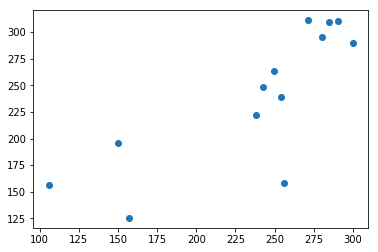

In [17]:
%matplotlib inline
plt.scatter(true, pred)

In [18]:
df = ru.pd_load(PATH+'/hp_df.csv')

In [19]:
df

,Unnamed: 0,filename,valence_pa,atomic_rad_pa_(angstroms),affinity_pa_(eV),ionization_potential_pa_(eV),electronegativity_pa,Crystal_Id,Crystal_ID#,Dom._Pore_(ang.),...,size_17,size_18,size_19,norm_vol_uptake,cat_1,cat_2,cat_3,cat_4,log_pressure,norm_log_pressure
0,0,hypotheticalMOF_5001133_i_0_j_19_k_7_m_2_cat_2...,1.2,1.232,-0.1878,10.236,2.008,-83,-83,4.25,...,-0.146257,-0.107573,-0.070888,-0.827323,0,0,1,0,0.000000,-0.992484
1,1,hypotheticalMOF_5009699_i_0_j_22_k_5_m_9_cat_2...,1.2,1.232,-0.1878,10.236,2.008,35,35,1.75,...,-0.146257,-0.107573,-0.070888,-1.076878,0,0,1,0,0.000000,-0.992484
2,2,hypotheticalMOF_3001230_i_2_j_24_k_23_m_1_cat_...,2.0,1.450,1.2360,7.730,1.900,-114,-114,12.75,...,-0.146257,-0.107573,-0.070888,-1.054830,0,0,1,0,0.000000,-0.992484
3,3,hypotheticalMOF_5022994_i_0_j_27_k_2_m_9_cat_2...,1.2,1.232,-0.1878,10.236,2.008,18,18,6.25,...,-0.146257,-0.107573,-0.070888,-0.940366,0,0,1,0,0.000000,-0.992484
4,4,hypotheticalMOF_5070517_i_2_j_24_k_19_m_2_cat_...,2.0,1.450,1.2360,7.730,1.900,-75,-75,1.75,...,-0.146257,-0.107573,-0.070888,-1.076878,0,1,0,0,0.000000,-0.992484
5,5,hypotheticalMOF_5028838_i_0_j_28_k_19_m_9_cat_...,1.2,1.232,-0.1878,10.236,2.008,-26,-26,6.25,...,-0.146257,-0.107573,-0.070888,-0.969578,0,1,0,0,0.000000,-0.992484
6,6,hypotheticalMOF_5061909_i_2_j_20_k_7_m_12.cif,2.0,1.450,1.2360,7.730,1.900,21,21,9.25,...,-0.146257,-0.107573,-0.070888,1.303599,1,0,0,0,5.513429,1.002509
7,7,hypotheticalMOF_33371_i_2_j_13_k_1_m_2.cif,2.0,1.450,1.2360,7.730,1.900,91,91,10.75,...,-0.146257,-0.107573,-0.070888,1.325678,1,0,0,0,5.513429,1.002509
8,8,hypotheticalMOF_34388_i_2_j_14_k_4_m_7.cif,2.0,1.450,1.2360,7.730,1.900,84,84,4.75,...,-0.146257,-0.107573,-0.070888,0.830107,1,0,0,0,5.513429,1.002509
9,9,hypotheticalMOF_22358_i_1_j_12_k_3_m_4.cif,2.0,1.420,-0.6000,9.390,1.650,86,86,3.25,...,-0.146257,-0.107573,-0.070888,-0.196065,1,0,0,0,5.513429,1.002509


# Scratch

In [4]:
a = np.array([1,3,2])

In [22]:
a.argmax()

1

In [18]:
b = {'a':[1]}

In [19]:
b['a'].append(2)

In [20]:
b

{'a': [1, 2]}

In [3]:
a = pd.DataFrame({'a':['hi','me']}).to_numpy()

In [8]:
np.random.randint(0, len(a), size=, )

array([2, 2])

In [9]:
np.random.choice(a, size=2, replace=False)

array([3, 2])

# Old